In [162]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

data = pd.read_csv('Hospitaltest.csv')
d = pd.read_csv("Hospital.csv")
#data.drop_duplicates(inplace=True)
data.drop(columns=[col for col in data.columns if 'unnamed' in col.lower()], inplace=True)
#d.drop_duplicates(inplace=True)
d.drop(columns=[col for col in d.columns if 'unnamed' in col.lower()],  inplace=True)
data = pd.concat([data, d], ignore_index=True)
colors = ['#64bb46', "#DDF1D6", "#21520F"]
#data[data["Parsed"]!=False].drop_duplicates(inplace=True)

data['Image'] = data.LLM.apply(lambda x: True if "image" in x.lower() else False)
data['Image'] = data['Image'].astype(bool)

# Updated LLM labeling to properly handle GLiNER models as zero-shot
def label_llm_with_prompt_type(row):
    llm_name = row['LLM']
    prompt = row['Prompt']
    
    # Check if it's a GLiNER model (various naming patterns)
    if 'GLiNER' in llm_name or 'gliner' in llm_name.lower():
        return llm_name + " (Zero-shot)"
    elif prompt == "LTNER/GPT-NER":
        return llm_name + " (One-shot)"
    elif prompt == "Normal":
        return llm_name + " (Zero-shot)"
    else:
        return llm_name

data['LLM'] = data.apply(label_llm_with_prompt_type, axis=1)
#plt.rcParams['font.family'] = 'Calibri'
#sns.set_theme(font='Calibri')



In [163]:

data.Prompt.fillna("None", inplace=True)
data.Parsed.fillna(True, inplace=True)

/var/folders/2r/vpjdzw2s7jl5204hqh_k3c9h0000gp/T/ipykernel_5588/2312198590.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data.Prompt.fillna("None", inplace=True)
/var/folders/2r/vpjdzw2s7jl5204hqh_k3c9h0000gp/T/ipykernel_5588/2312198590.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

In [164]:
data.isnull().sum()

LLM                         0
False Positives          2917
False Negatives          2917
Incorrect Extractions    2917
Correct Matches          2917
Precision                2917
Recall                   2917
F1score                  2917
Accuracy                 2917
Parsed                      0
Hospital                    0
Prompt                      0
Distressed                  0
Image                       0
dtype: int64

In [165]:
# Ensure F1score is numeric
data['F1score'] = pd.to_numeric(data['F1score'], errors='coerce')
df = data.copy()
 # Keep all models for now
#df.drop(data[data["LLM"].str.contains("gpt")].index, inplace=True)
# Group by LLM, Image, and Prompt, and calculate the mean F1score
g = df.groupby(["LLM", "Image", "Prompt"]).F1score.mean().sort_values(ascending=False)
g

LLM                                       Image  Prompt       
gpt-4.1-mini (One-shot)                   False  LTNER/GPT-NER    55.621716
gpt-4.1-mini (Zero-shot)                  False  Normal           52.957670
gemma327b*ImageInput* (Zero-shot)         True   Normal           41.329863
gemma327b*ImageInput* (One-shot)          True   LTNER/GPT-NER    37.555105
llama3.170b (Zero-shot)                   False  Normal           29.014723
llama3.170b (One-shot)                    False  LTNER/GPT-NER    27.849322
mistral(24b)*ImageInput* (Zero-shot)      True   Normal           23.782017
mistral(24b) (Zero-shot)                  False  Normal           23.656551
gpt-4.1-mini*ImageInput* (One-shot)       True   LTNER/GPT-NER    23.307252
NuExtract:4B                              False  None             23.072817
mistral(24b)*ImageInput* (One-shot)       True   LTNER/GPT-NER    22.652706
gpt-4.1-mini*ImageInput* (Zero-shot)      True   Normal           20.188961
mistral(24b) (One-shot)  

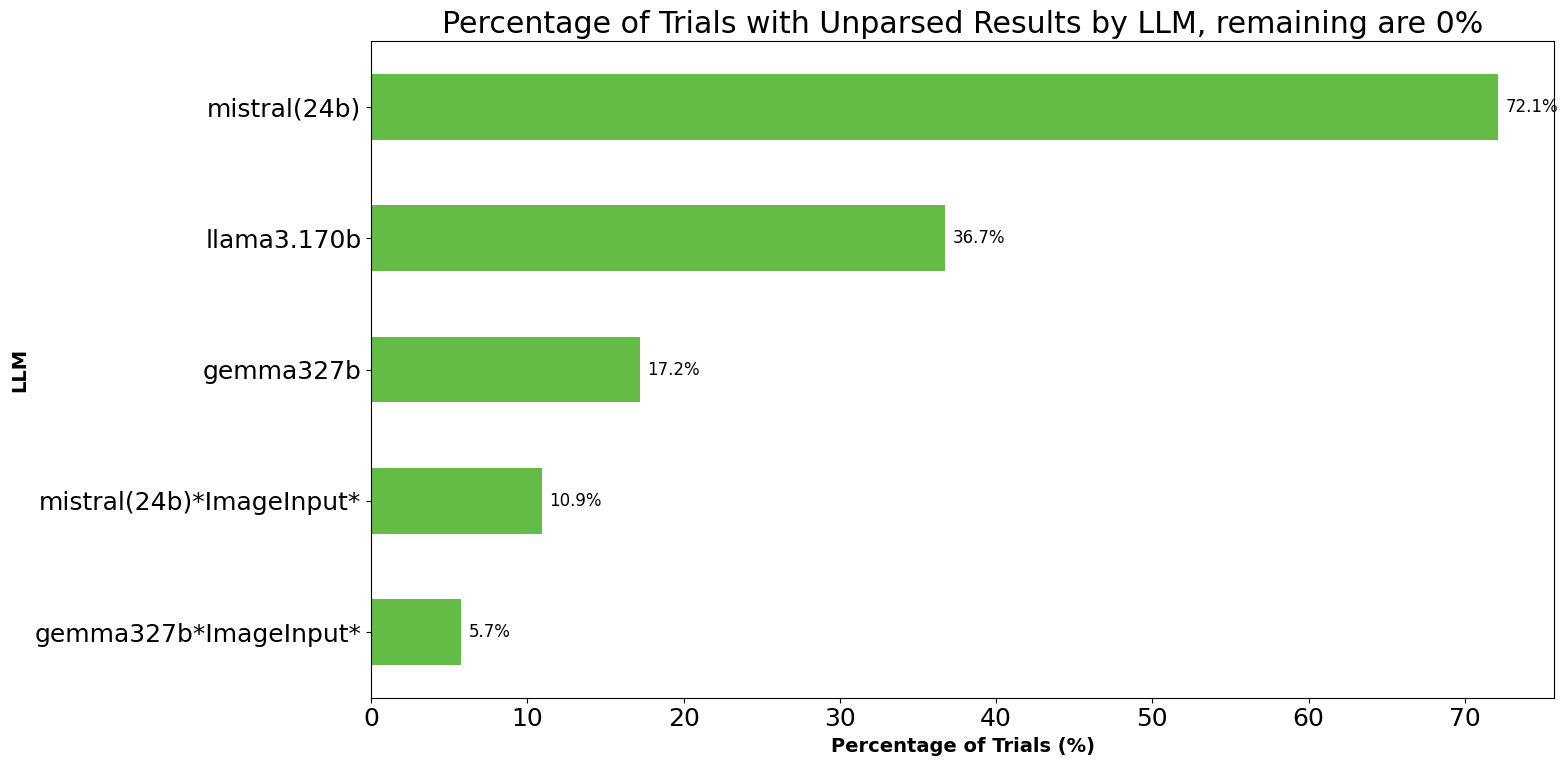

In [166]:
# Calculate percentage of unparsed results by LLM
data["BaseLLM"] = data.LLM.apply(lambda x: x.split(" (")[0]).replace("*ImageInput*", " (Image Input)")

unparsed_counts = data.loc[data["Parsed"] == False].BaseLLM.value_counts()
total_counts = data.BaseLLM.value_counts()
unparsed_percentages = (unparsed_counts / total_counts * 100).fillna(0)
# Sort by percentage for better visualization
unparsed_percentages = unparsed_percentages.sort_values(ascending=True)
unparsed_percentages = unparsed_percentages[unparsed_percentages > 0]
ax = unparsed_percentages.plot(kind='barh', color=colors[0], figsize=(16, 8))
plt.title("Percentage of Trials with Unparsed Results by LLM, remaining are 0%")
plt.xlabel("Percentage of Trials (%)", fontsize=14, fontweight='bold')
plt.ylabel("LLM", fontdict={'size': 14, 'weight': 'bold'})

# Add percentage labels on bars
for i, (model, percentage) in enumerate(unparsed_percentages.items()):
    ax.text(percentage + 0.5, i, f'{percentage:.1f}%', 
           va='center', ha='left', fontsize=12, color='black')

plt.tight_layout()
plt.show()

In [167]:
data.Hospital.value_counts()
data["Error Rate"] = data["Hospital"]

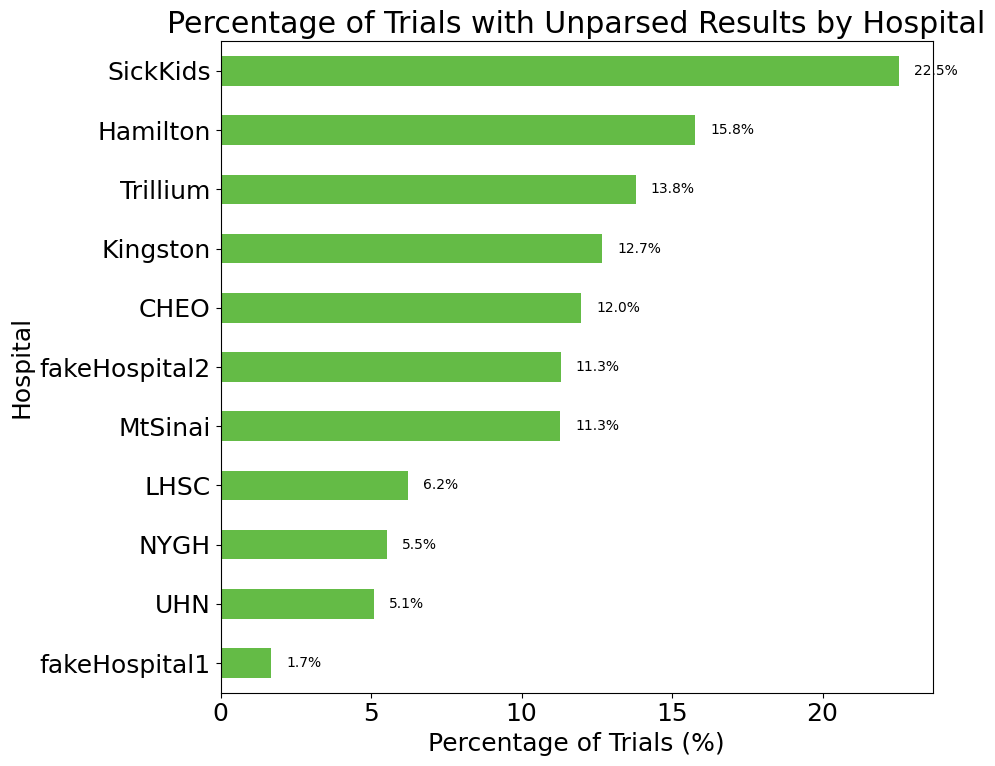

In [168]:
# Calculate percentage of unparsed results by Hospital
unparsed_counts_hospital = data.loc[data["Parsed"] == False].Hospital.value_counts()
total_counts_hospital = data.loc[(data["Parsed"] == True) | (data["Parsed"] == False)].Hospital.value_counts()
unparsed_percentages_hospital = (unparsed_counts_hospital / total_counts_hospital * 100).fillna(0)

# Sort by percentage for better visualization
unparsed_percentages_hospital = unparsed_percentages_hospital.sort_values(ascending=True)

ax = unparsed_percentages_hospital.plot(kind='barh', color=colors[0], figsize=(10, 8))
plt.title("Percentage of Trials with Unparsed Results by Hospital")
plt.xlabel("Percentage of Trials (%)")
plt.ylabel("Hospital")

# Add percentage labels on bars
for i, (hospital, percentage) in enumerate(unparsed_percentages_hospital.items()):
    ax.text(percentage + 0.5, i, f'{percentage:.1f}%', 
           va='center', ha='left', fontsize=10, color='black')

plt.tight_layout()
plt.show()

In [169]:
unparsed_counts_hospital = data.loc[data["Parsed"] == False].Distressed.value_counts()
unparsed_counts_hospital

Distressed
True     1755
False    1162
Name: count, dtype: int64

# Key table

In [192]:
stat = data.copy()
stat.drop(columns=[col for col in stat.columns if 'unnamed' in col.lower()], inplace=True)
stat.drop(index=stat[stat.LLM.str.contains('GLiNER')].index, inplace=True)


In [193]:
stat['Image'] = stat['LLM'].apply(lambda x: True if 'ImageInput' in x else False)
stat['LLM'] = stat['LLM'].apply(lambda x: x.replace('*ImageInput*', ""))


In [194]:
stat.groupby(["Image", "Prompt"]).F1score.mean().sort_values(ascending=False)
stats_pivot = stat.pivot_table(index='Prompt', columns = 'Image', values='F1score', aggfunc='mean')

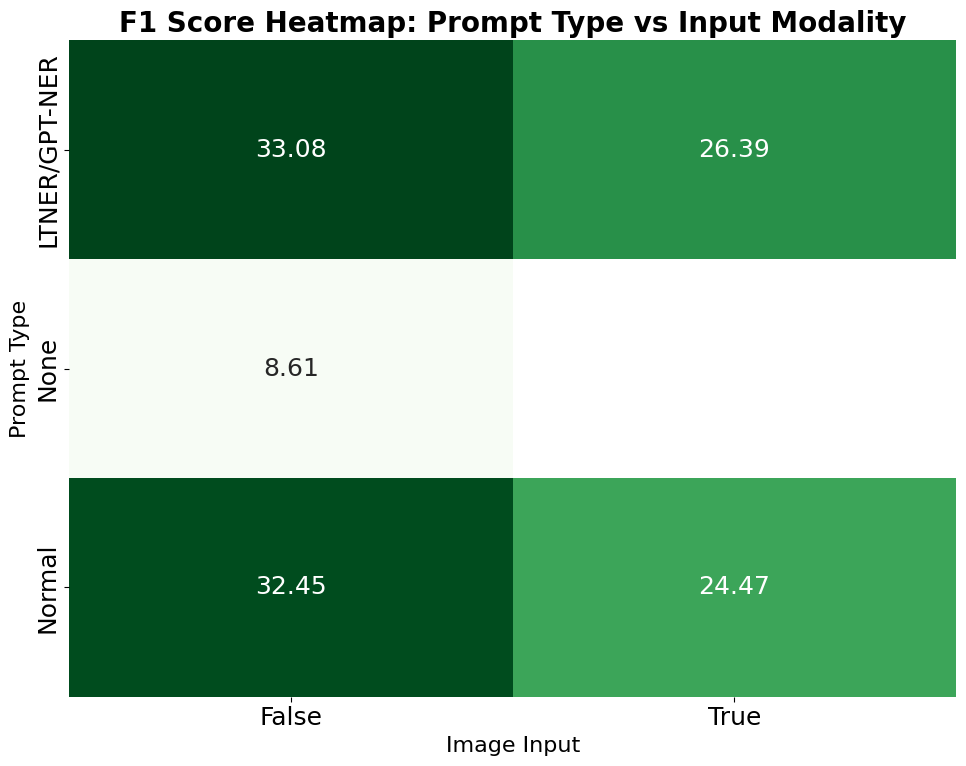


Statistical Comparison Between Prompt Types:
Overall One-shot vs Zero-shot:
  One-shot mean F1: 29.39 (n=6255)
  Zero-shot mean F1: 21.72 (n=8541)
  p-value: 0.000000 (***)

By Input Modality:
  Text Input:
    One-shot mean F1: 33.08 (n=2804)
    Zero-shot mean F1: 20.27 (n=5591)
    p-value: 0.000000 (***)

  Image Input:
    One-shot mean F1: 26.39 (n=3451)
    Zero-shot mean F1: 24.47 (n=2950)
    p-value: 0.000000 (***)

Significance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant


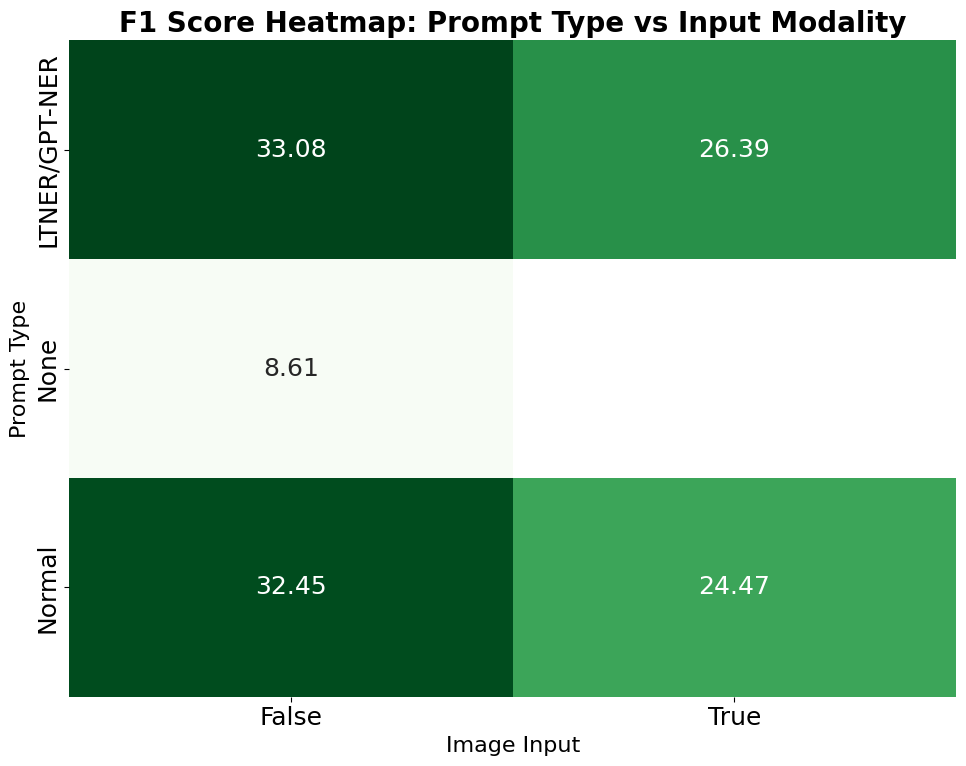

In [ ]:
from scipy.stats import mannwhitneyu, ttest_ind
from scipy import stats

plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 18})

sns.heatmap(stats_pivot, annot=True, fmt='.2f', cmap='Greens', cbar = False)
plt.title('F1 Score Heatmap: Prompt Type vs Input Modality', fontsize=20, fontweight='bold')
plt.xlabel('Image Input', fontsize=16)
plt.ylabel('Prompt Type', fontsize=16)
plt.tight_layout()
plt.show()

# Perform statistical testing between prompt types

def perform_statistical_test(group1, group2):
    """Perform Mann-Whitney U test between two groups"""
    
    # Remove NaN values
    group1 = group1.dropna()
    group2 = group2.dropna()
    
    if len(group1) < 3 or len(group2) < 3:
        return 1.0  # Return non-significant if insufficient data
    
    try:
        _, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
        return p_value
    except:
        return 1.0

def get_significance_symbol(p_value):
    """Convert p-value to significance symbol"""
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return 'ns'

# Filter data for statistical testing
stats_data = stat.copy()
stats_data = stats_data[stats_data['Parsed'] == True]
stats_data['F1score'] = pd.to_numeric(stats_data['F1score'], errors='coerce')
stats_data = stats_data.dropna(subset=['F1score'])

# Create prompt type mapping
stats_data['Prompt_Type'] = stats_data['Prompt'].map({
    'LTNER/GPT-NER': 'One-shot',
    'Normal': 'Zero-shot',
    'None': 'Zero-shot'
})
# Create prompt mapping for consistency
prompt_mapping = {
    'LTNER/GPT-NER': 'One-shot',
    'Normal': 'Zero-shot',
    'None': 'Zero-shot'
}

# Get the axes object from the current figure
fig, ax = plt.subplots(figsize=(10, 8))
plt.rcParams.update({'font.size': 18})

# Create the heatmap with annotations
sns.heatmap(stats_pivot, annot=True, fmt='.2f', cmap='Greens', cbar=False, ax=ax)
plt.title('F1 Score Heatmap: Prompt Type vs Input Modality', fontsize=20, fontweight='bold')
plt.xlabel('Image Input', fontsize=16)
plt.ylabel('Prompt Type', fontsize=16)
plt.tight_layout()
print("\nStatistical Comparison Between Prompt Types:")
print("=" * 60)
# Add statistical significance to heatmap
for i, prompt_type1 in enumerate(stats_pivot.index):
    for j, image_status in enumerate(stats_pivot.columns):
        # Get data for current cell
        current_data = stats_data[
            (stats_data['Prompt'].map(prompt_mapping) == prompt_type1) & 
            (stats_data['Image'] == image_status)
        ]['F1score']
        
        if len(current_data) > 0:
            # Compare with other prompt types for same image status
            for k, prompt_type2 in enumerate(stats_pivot.index):
                if k != i:  # Don't compare with itself
                    comparison_data = stats_data[
                        (stats_data['Prompt'].map(prompt_mapping) == prompt_type2) & 
                        (stats_data['Image'] == image_status)
                    ]['F1score']
                    
                    if len(comparison_data) > 0:
                        p_val = perform_statistical_test(current_data, comparison_data)
                        sig_symbol = get_significance_symbol(p_val)
                        
                        # Add significance annotation below the mean value
                        if sig_symbol != 'ns':
                            ax.text(j, i + 0.15, sig_symbol, ha='center', va='center', 
                                   fontsize=12, fontweight='bold', color='red',
                                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', 
                                           alpha=0.9, edgecolor='gray', linewidth=1))

annotations = []
        for model in f1_pivot.index:
            normal_f1 = f1_pivot.loc[model, 'Normal']
            oneshot_f1 = f1_pivot.loc[model, 'LTNER/GPT-NER']
            change = f1_pivot.loc[model, 'F1_Change']
            significance = f1_pivot.loc[model, 'Significance']
            annotations.append([f'{normal_f1:.1f} → {oneshot_f1:.1f}\n({change:+.1f}) {significance}'])
# Overall comparison between prompt types
if 'One-shot' in stats_data['Prompt_Type'].values and 'Zero-shot' in stats_data['Prompt_Type'].values:
    one_shot_all = stats_data[stats_data['Prompt_Type'] == 'One-shot']['F1score']
    zero_shot_all = stats_data[stats_data['Prompt_Type'] == 'Zero-shot']['F1score']
    
    overall_p = perform_statistical_test(one_shot_all, zero_shot_all)
    overall_sig = get_significance_symbol(overall_p)
    
    print(f"Overall One-shot vs Zero-shot:")
    print(f"  One-shot mean F1: {one_shot_all.mean():.2f} (n={len(one_shot_all)})")
    print(f"  Zero-shot mean F1: {zero_shot_all.mean():.2f} (n={len(zero_shot_all)})")
    print(f"  p-value: {overall_p:.6f} ({overall_sig})")
    print()

# Comparison by input modality
print("By Input Modality:")
for image_status in [False, True]:
    modality = "Image Input" if image_status else "Text Input"
    modality_data = stats_data[stats_data['Image'] == image_status]
    
    if len(modality_data) > 0:
        one_shot_mod = modality_data[modality_data['Prompt_Type'] == 'One-shot']['F1score']
        zero_shot_mod = modality_data[modality_data['Prompt_Type'] == 'Zero-shot']['F1score']
        
        if len(one_shot_mod) > 0 and len(zero_shot_mod) > 0:
            mod_p = perform_statistical_test(one_shot_mod, zero_shot_mod)
            mod_sig = get_significance_symbol(mod_p)
            
            print(f"  {modality}:")
            print(f"    One-shot mean F1: {one_shot_mod.mean():.2f} (n={len(one_shot_mod)})")
            print(f"    Zero-shot mean F1: {zero_shot_mod.mean():.2f} (n={len(zero_shot_mod)})")
            print(f"    p-value: {mod_p:.6f} ({mod_sig})")
            print()

print("Significance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")


# models with both promp types and change in score

/var/folders/2r/vpjdzw2s7jl5204hqh_k3c9h0000gp/T/ipykernel_5588/1667880178.py:210: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


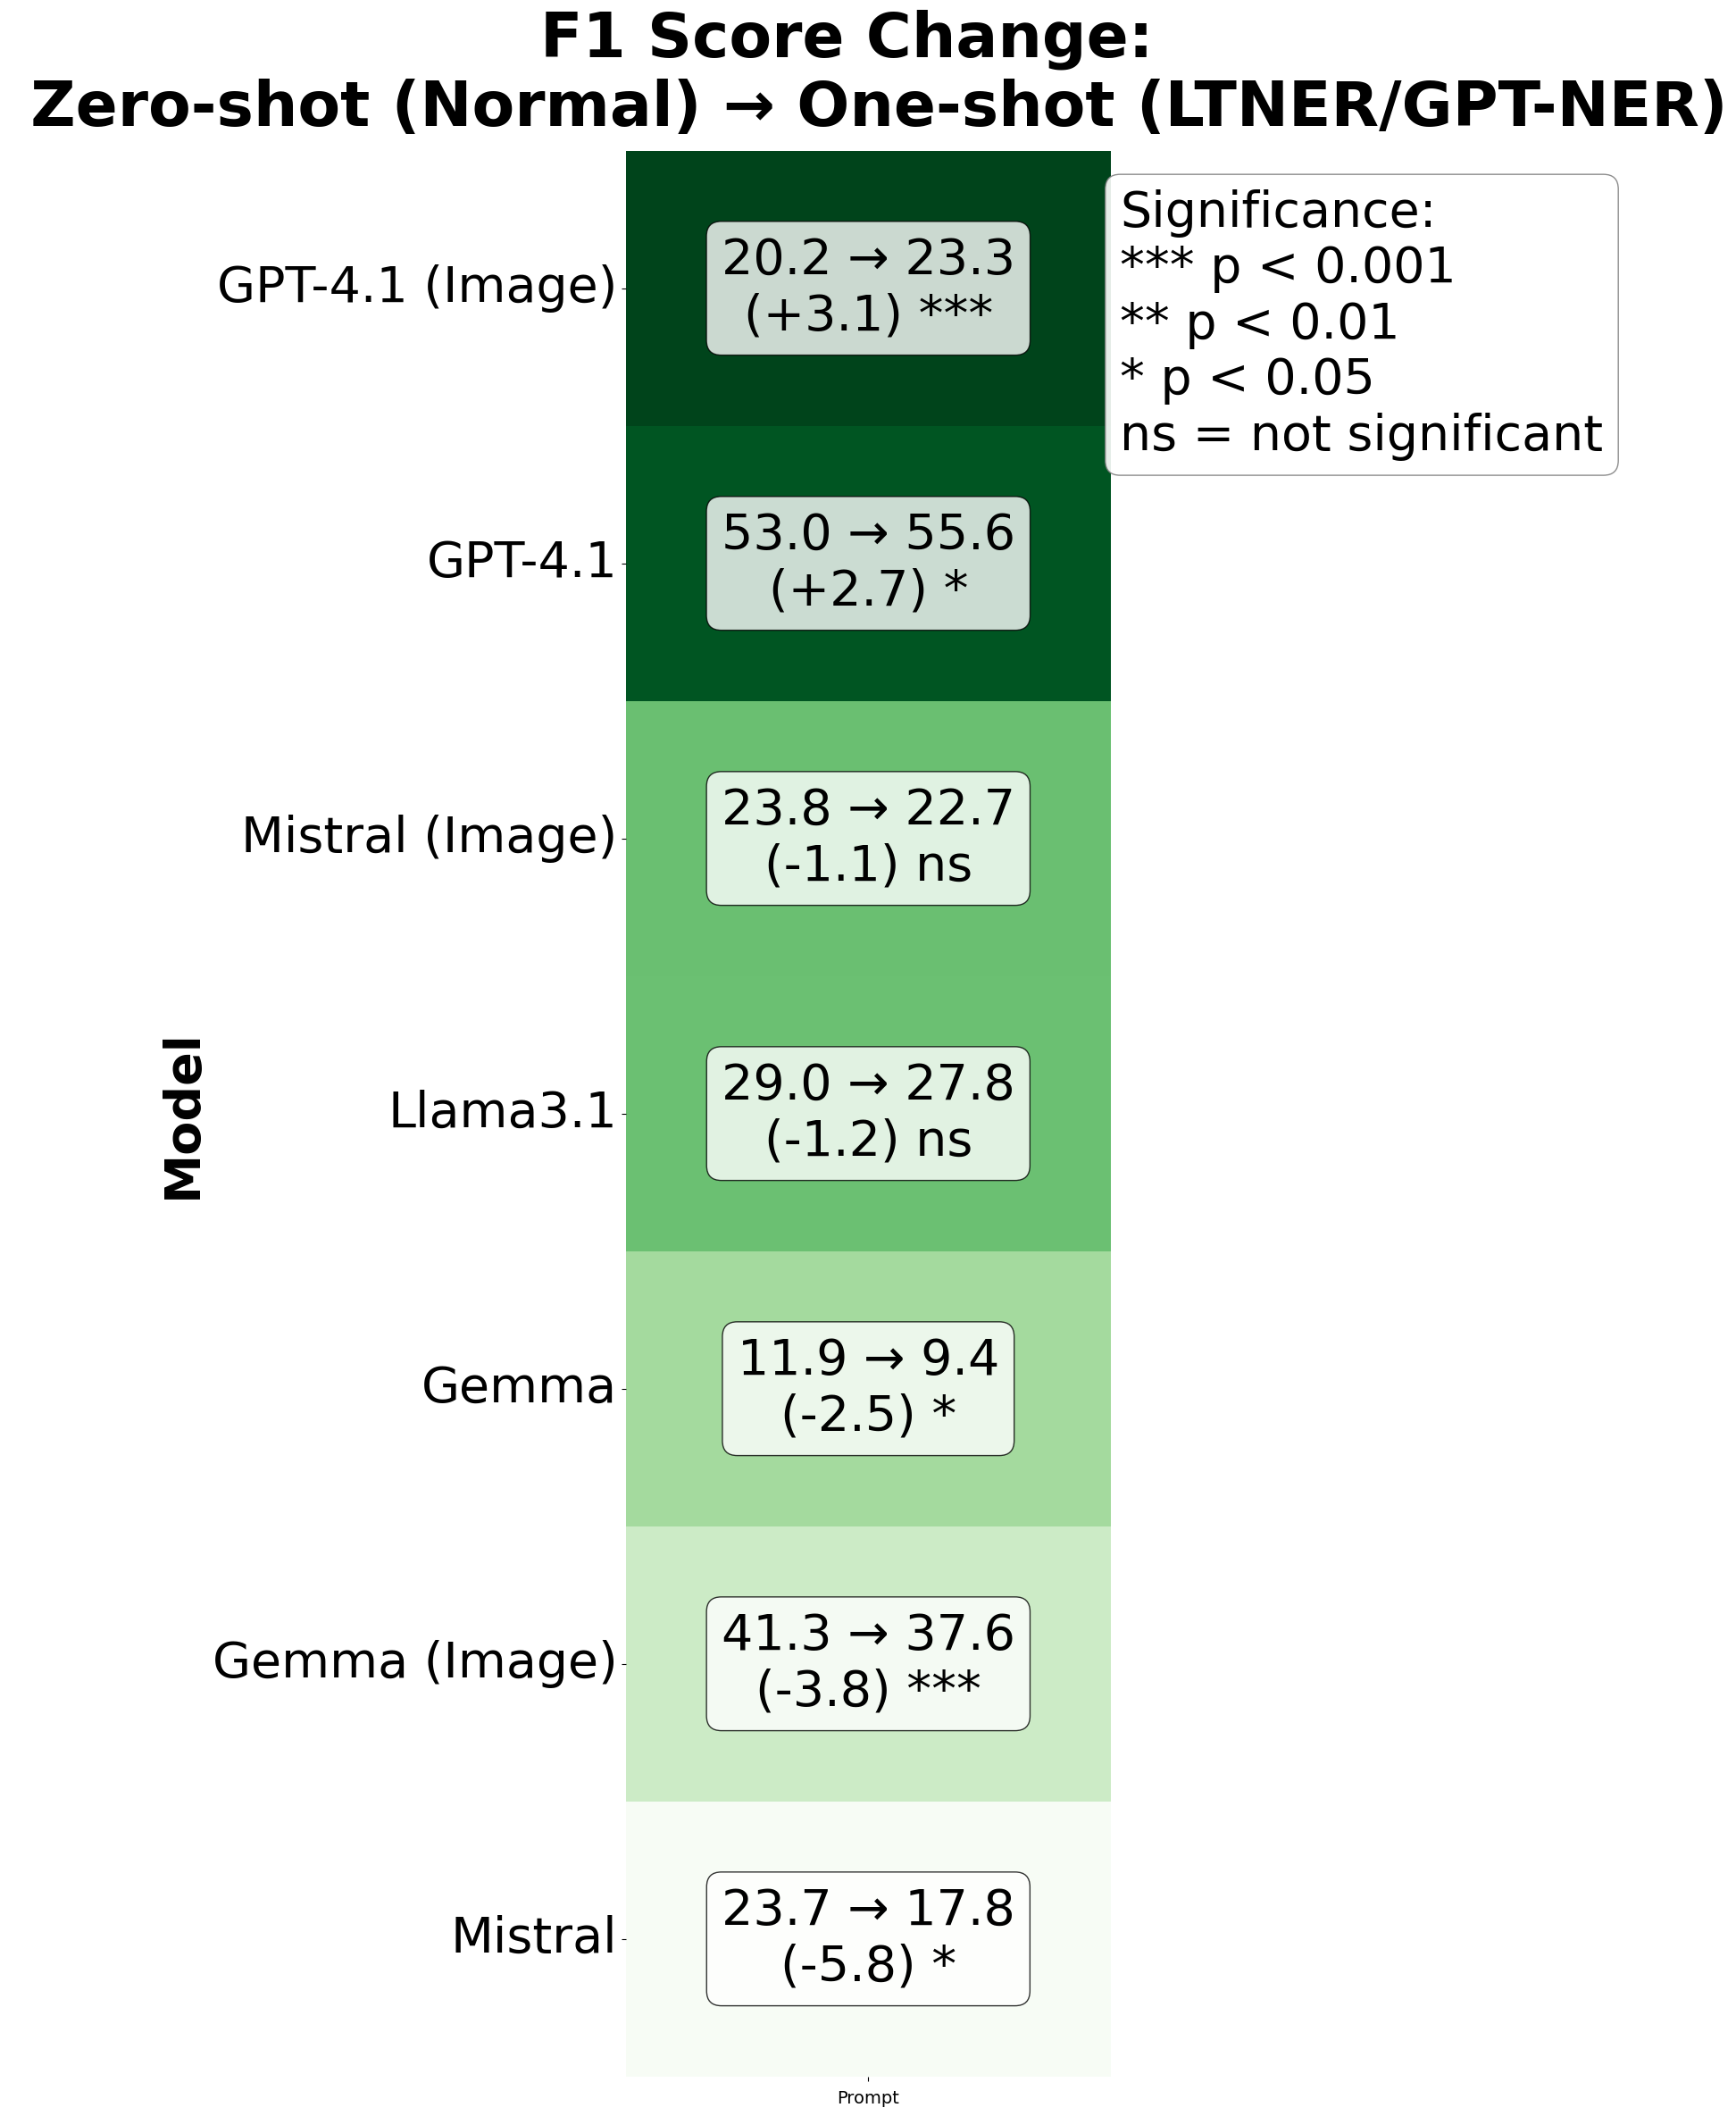

In [174]:
# F1 Score Change Heatmap: Models with Both Prompt Types (Text and Image Input)
# Import required statistical packages
from scipy.stats import mannwhitneyu, ttest_ind, normaltest, wilcoxon
from statsmodels.stats.multitest import multipletests
import numpy as np

def get_significance_symbol(p_value):
    """Convert p-value to significance symbol"""
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return 'ns'

def perform_paired_test(zero_shot_scores, one_shot_scores):
    """Perform paired statistical test for F1 score changes"""
    from scipy import stats
    
    # Remove NaN values and ensure same length
    zero_shot_clean = zero_shot_scores.dropna()
    one_shot_clean = one_shot_scores.dropna()
    
    if len(zero_shot_clean) < 3 or len(one_shot_clean) < 3:
        return 1.0, 'insufficient_data'
    
    # For paired data, we need matching observations
    # Get the intersection of indices
    common_indices = zero_shot_clean.index.intersection(one_shot_clean.index)
    
    if len(common_indices) < 3:
        # Use unpaired test if we don't have paired observations
        try:
            _, p_value = mannwhitneyu(zero_shot_clean, one_shot_clean, alternative='two-sided')
            return p_value, 'unpaired'
        except:
            return 1.0, 'error'
    
    # Use paired observations
    zero_paired = zero_shot_clean.loc[common_indices]
    one_paired = one_shot_clean.loc[common_indices]
    
    try:
        # Test for normality of differences
        differences = one_paired - zero_paired
        
        if len(differences) >= 8:  # Need at least 8 samples for reliable normality test
            _, p_norm = normaltest(differences)
            if p_norm > 0.05:
                # Differences are normal - use paired t-test
                _, p_value = stats.ttest_rel(one_paired, zero_paired)
                return p_value, 'paired_ttest'
        
        # Use Wilcoxon signed-rank test (non-parametric paired test)
        _, p_value = wilcoxon(one_paired, zero_paired, alternative='two-sided')
        return p_value, 'wilcoxon'
        
    except Exception as e:
        # Fallback to Mann-Whitney U test
        try:
            _, p_value = mannwhitneyu(zero_shot_clean, one_shot_clean, alternative='two-sided')
            return p_value, 'fallback_unpaired'
        except:
            return 1.0, 'error'

# Prepare data for change analysis
df_change = data.copy()
df_change = df_change[df_change['Parsed'] == True]  # Only successfully parsed data
df_change['F1score'] = pd.to_numeric(df_change['F1score'], errors='coerce')
df_change = df_change.dropna(subset=['F1score'])

# Clean up model names and create display names
df_change['Model_Base'] = df_change['LLM'].str.replace('*ImageInput*', '').str.replace(' (One-shot)', '').str.replace(' (Zero-shot)', '')
df_change['Model_Display'] = df_change.apply(
    lambda row: f"{row['Model_Base']} (Image)" if row['Image'] == True else row['Model_Base'],
    axis=1
)

# Only include models that have data for both LTNER/GPT-NER and Normal prompts
prompt_counts = df_change.groupby('Model_Display')['Prompt'].nunique()
models_with_both_prompts = prompt_counts[prompt_counts >= 2].index.tolist()

# Filter to only models with both prompt types
df_both_prompts = df_change[df_change['Model_Display'].isin(models_with_both_prompts)]

# Calculate mean F1 scores for each model-prompt combination
f1_by_model_prompt = df_both_prompts.groupby(['Model_Display', 'Prompt'])['F1score'].mean().reset_index()

# Pivot to get prompt types as columns
f1_pivot = f1_by_model_prompt.pivot(index='Model_Display', columns='Prompt', values='F1score')

# Only keep models that have both LTNER/GPT-NER and Normal prompts
f1_pivot = f1_pivot.dropna()

if len(f1_pivot) > 0:
    # Calculate the change from Normal to LTNER/GPT-NER (One-shot - Zero-shot)
    if 'LTNER/GPT-NER' in f1_pivot.columns and 'Normal' in f1_pivot.columns:
        f1_pivot['F1_Change'] = f1_pivot['LTNER/GPT-NER'] - f1_pivot['Normal']
        
        # Perform statistical testing for each model
        significance_results = []
        p_values_raw = []
        test_methods = []
        
        for model in f1_pivot.index:
            # Get raw F1 scores for this model
            model_data = df_both_prompts[df_both_prompts['Model_Display'] == model]
            
            zero_shot_scores = model_data[model_data['Prompt'] == 'Normal']['F1score']
            one_shot_scores = model_data[model_data['Prompt'] == 'LTNER/GPT-NER']['F1score']
            
            p_value, test_method = perform_paired_test(zero_shot_scores, one_shot_scores)
            p_values_raw.append(p_value)
            test_methods.append(test_method)
            significance_results.append((model, p_value, test_method))
        
        # Apply Benjamini-Hochberg correction for multiple comparisons
        if len(p_values_raw) > 1:
            rejected, p_corrected, _, _ = multipletests(p_values_raw, method='fdr_bh')
        else:
            p_corrected = p_values_raw
            rejected = [p < 0.05 for p in p_values_raw]
        
        # Add corrected p-values and significance to results
        for i, (model, p_raw, test_method) in enumerate(significance_results):
            p_corrected_val = p_corrected[i] if i < len(p_corrected) else 1.0
            significance = get_significance_symbol(p_corrected_val)
            significance_results[i] = (model, p_raw, p_corrected_val, significance, test_method)
        
        # Add significance to the pivot table
        f1_pivot['Significance'] = [sig for _, _, _, sig, _ in significance_results]
        f1_pivot['P_Value_Corrected'] = [p_corr for _, _, p_corr, _, _ in significance_results]
        
        # Sort by the magnitude of change (largest improvement first)
        f1_pivot = f1_pivot.sort_values('F1_Change', ascending=False)
        
        # Create the vertical change heatmap
        fig, ax = plt.subplots(figsize=(7, 28))
        
        # Create a dataframe with just the change values for visualization
        change_data = f1_pivot[['F1_Change']]
        
        # Create annotations with F1 scores, change, and significance
        annotations = []
        for model in f1_pivot.index:
            normal_f1 = f1_pivot.loc[model, 'Normal']
            oneshot_f1 = f1_pivot.loc[model, 'LTNER/GPT-NER']
            change = f1_pivot.loc[model, 'F1_Change']
            significance = f1_pivot.loc[model, 'Significance']
            annotations.append([f'{normal_f1:.1f} → {oneshot_f1:.1f}\n({change:+.1f}) {significance}'])
        # Create a mapping to simplify model names
        def simplify_model_name(model_name):
            """Convert full model names to simplified versions"""
            if 'gpt-4.1-mini' in model_name.lower():
                if '(Image)' in model_name:
                    return 'GPT-4.1 (Image)'
                else:
                    return 'GPT-4.1'
            elif 'llama3.170b' in model_name.lower():
                if '(Image)' in model_name:
                    return 'Llama3.1 (Image)'
                else:
                    return 'Llama3.1'
            elif 'gemma327b' in model_name.lower():
                if '(Image)' in model_name:
                    return 'Gemma (Image)'
                else:
                    return 'Gemma'
            elif 'mistral(24b)' in model_name.lower():
                if '(Image)' in model_name:
                    return 'Mistral (Image)'
                else:
                    return 'Mistral'
            else:
                return model_name

        # Apply the simplification to the index
        f1_pivot.index = [simplify_model_name(name) for name in f1_pivot.index]

        # Update annotations with simplified names
        annotations = []
        for model in f1_pivot.index:
            normal_f1 = f1_pivot.loc[model, 'Normal']
            oneshot_f1 = f1_pivot.loc[model, 'LTNER/GPT-NER']
            change = f1_pivot.loc[model, 'F1_Change']
            significance = f1_pivot.loc[model, 'Significance']
            annotations.append([f'{normal_f1:.1f} → {oneshot_f1:.1f}\n({change:+.1f}) {significance}'])
        # Create the vertical heatmap
        sns.heatmap(change_data, 
                   annot=annotations, 
                   fmt='', cmap='Greens', 
            cbar=False, ax=ax, annot_kws={'fontsize': 40, 'color':'black', 'bbox':dict(boxstyle='round', facecolor='white', alpha=0.8)})
        
        # Customize the plot with same formatting as previous graph
        ax.set_title('F1 Score Change:  \n Zero-shot (Normal) → One-shot (LTNER/GPT-NER)', 
                    fontsize=50, fontweight='bold', pad=20)
        ax.set_ylabel('Model', fontsize=40, fontweight='bold')
        ax.set_xticklabels([''], rotation=0, fontsize=40)
        ax.set_yticklabels(f1_pivot.index, rotation=0, fontsize=40)
        
        # Add a text box explaining the format
        textstr = ('Significance:\n*** p < 0.001\n** p < 0.01\n'
                  '* p < 0.05\nns = not significant')
        props = dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray')
        ax.text(1.02, 0.98, textstr, transform=ax.transAxes, fontsize=40,
               verticalalignment='top', bbox=props)
        
        plt.tight_layout()
        plt.show()



# unusued bar chart witih stats

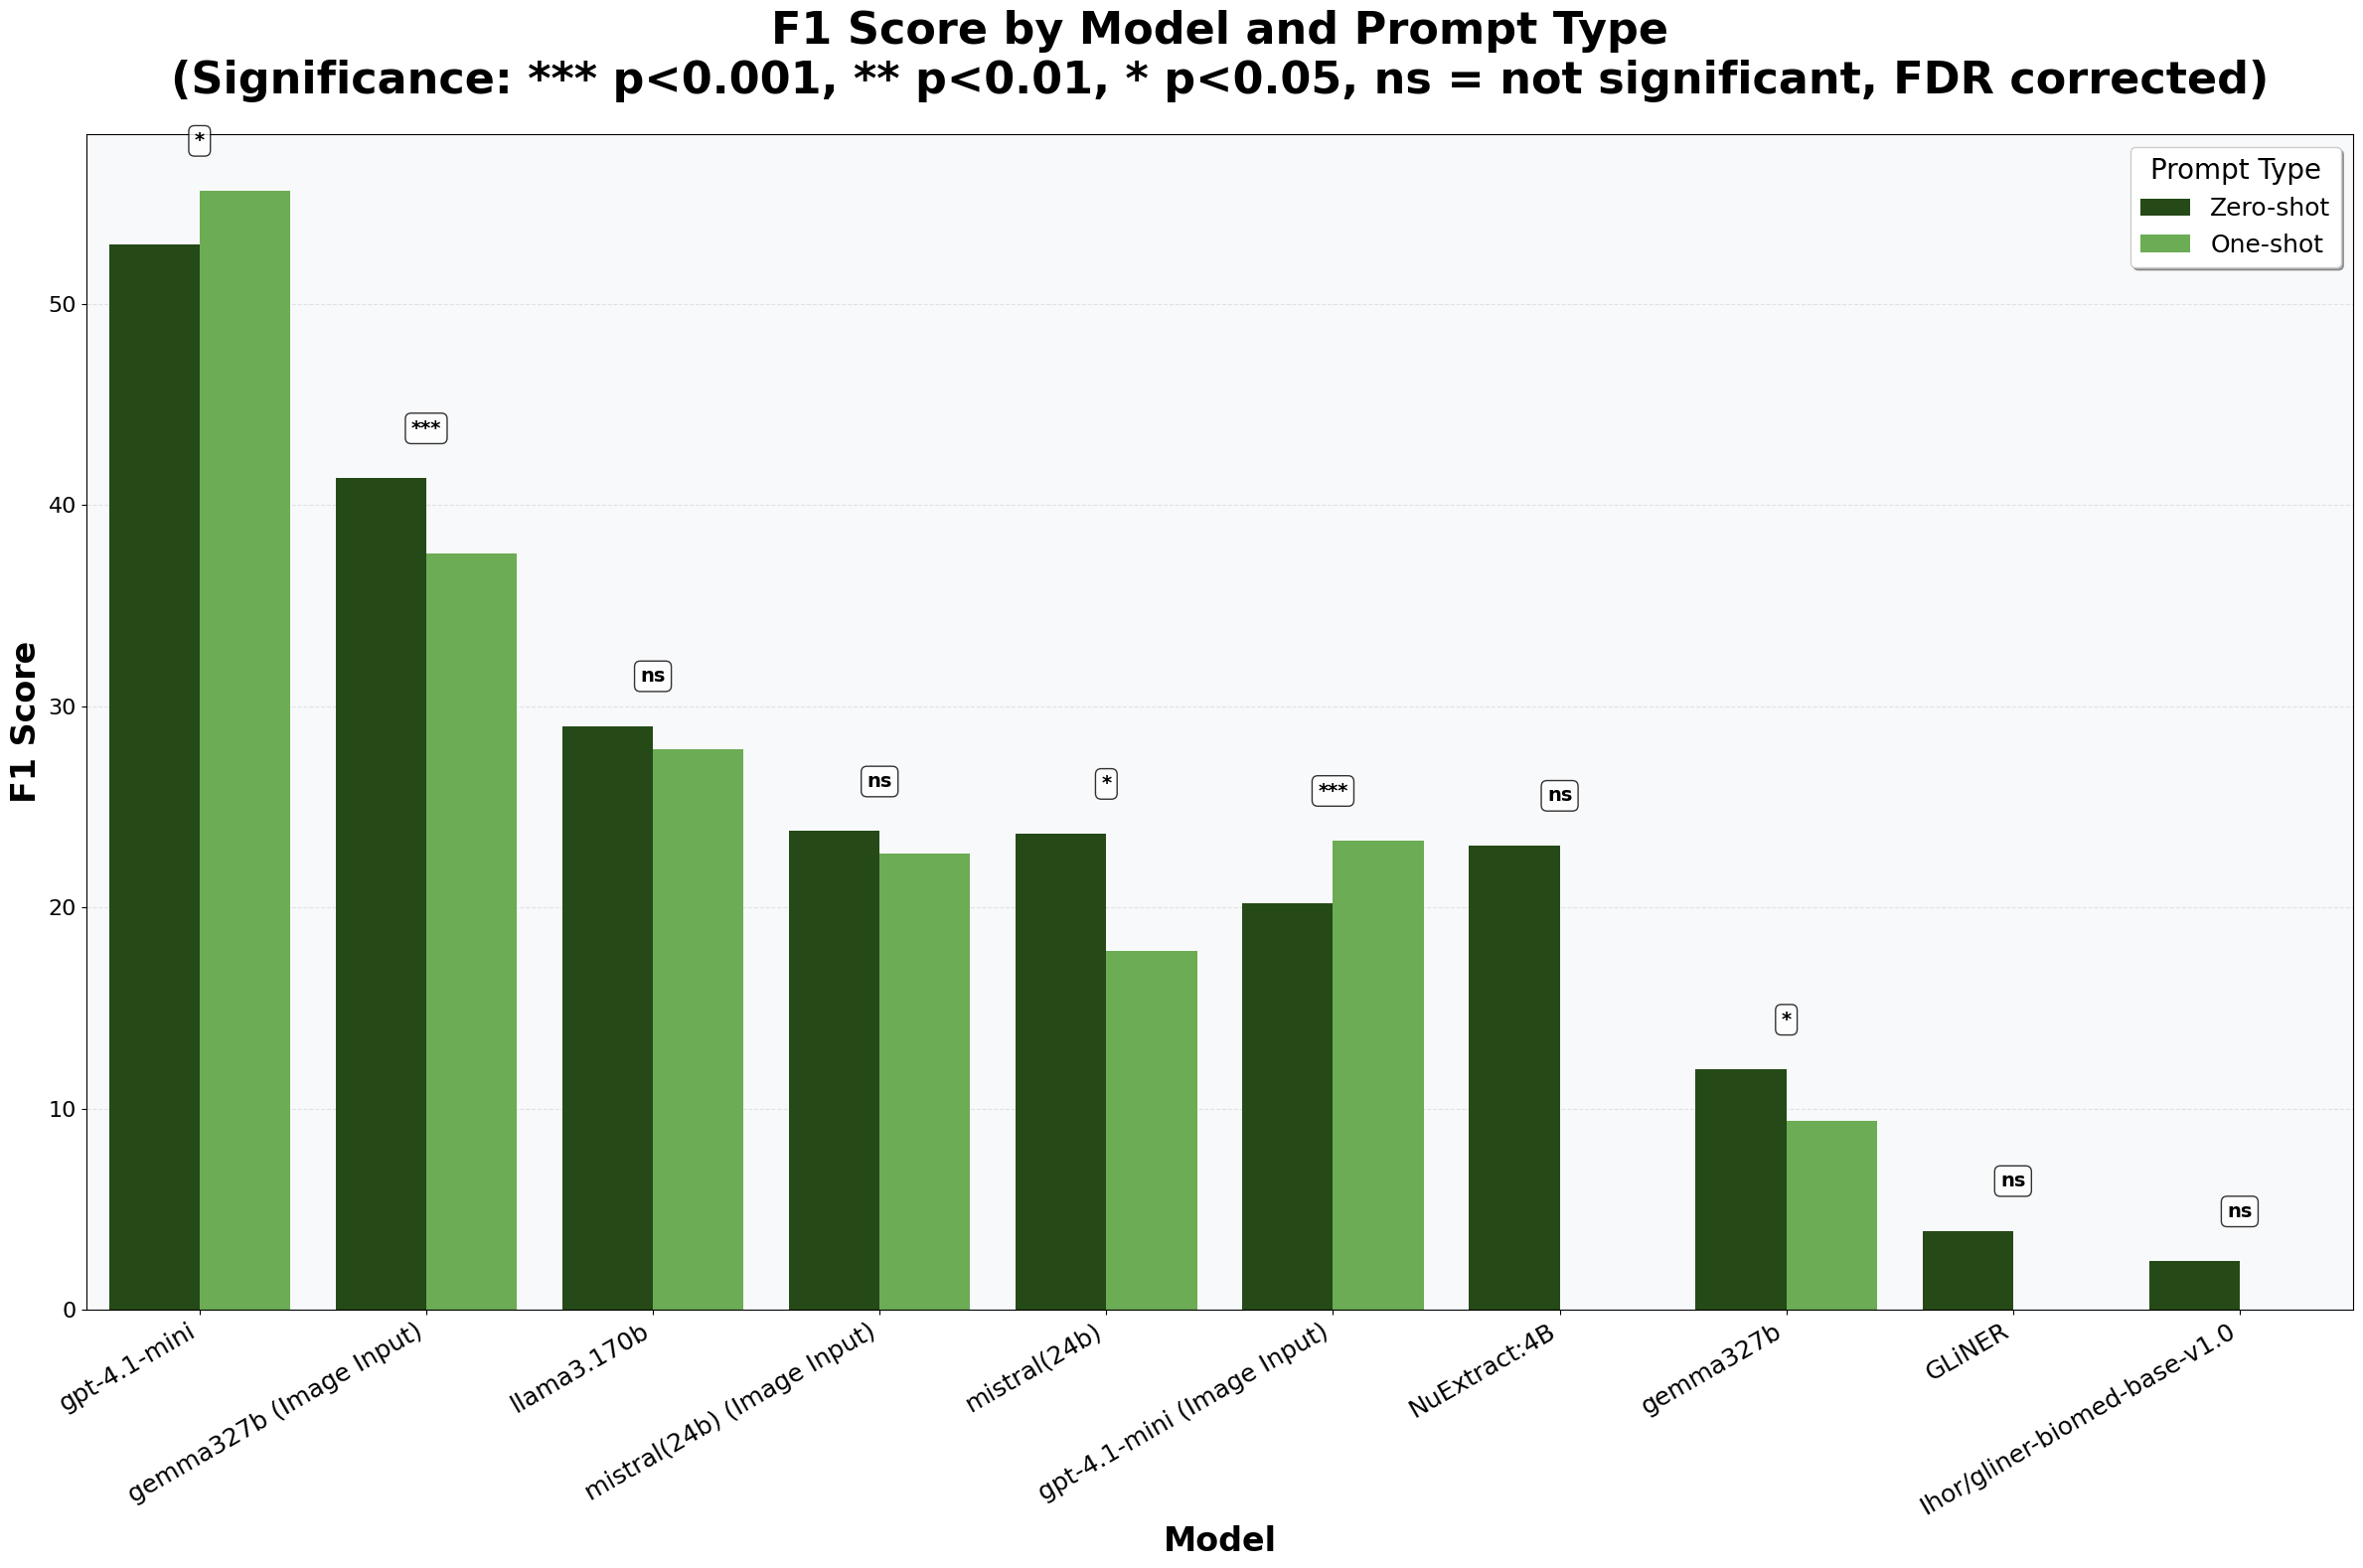

In [175]:
# Enhanced F1 Score visualization with corrected significance testing
from scipy.stats import mannwhitneyu, ttest_ind, normaltest
from statsmodels.stats.multitest import multipletests
import numpy as np

def get_significance_symbol(p_value):
    """Convert p-value to significance symbol"""
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return 'ns'

def perform_statistical_test(group1, group2):
    """Perform appropriate statistical test and return p-value"""
    from scipy import stats
    
    # Remove NaN values
    group1 = group1.dropna()
    group2 = group2.dropna()
    
    if len(group1) < 3 or len(group2) < 3:
        return 1.0  # Return non-significant if insufficient data
    
    # Use D'Agostino-Pearson test for normality (better for larger samples)
    try:
        _, p_norm1 = normaltest(group1)
        _, p_norm2 = normaltest(group2)
        
        # Check for equal variances
        _, p_levene = stats.levene(group1, group2)
        
        if p_norm1 > 0.05 and p_norm2 > 0.05:
            # Both normal - use t-test
            equal_var = p_levene > 0.05
            _, p_value = ttest_ind(group1, group2, equal_var=equal_var)
        else:
            # Non-normal - use Mann-Whitney U test
            _, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
        return p_value
    except:
        # Fallback to Mann-Whitney U if normality test fails
        try:
            _, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
            return p_value
        except:
            return 1.0

# Prepare data for significance testing
df_clean = data.copy()
df_clean = df_clean[df_clean['Parsed'] == True]  # Only use successfully parsed data
df_clean['F1score'] = pd.to_numeric(df_clean['F1score'], errors='coerce')
df_clean = df_clean.dropna(subset=['F1score'])

# Clean up model names and create proper groupings
df_clean['Model_Base'] = df_clean['LLM'].str.replace('*ImageInput*', '').str.replace(' (One-shot)', '').str.replace(' (Zero-shot)', '')
df_clean['Input_Type'] = df_clean['LLM'].apply(lambda x: 'Image Input' if '*ImageInput*' in x else 'Text Input')
df_clean['Prompt_Type'] = df_clean['Prompt'].map({
    'LTNER/GPT-NER': 'One-shot',
    'Normal': 'Zero-shot',
    'None': 'Zero-shot'
})

# Create final model name with input type indicator
df_clean['Final_Model_Name'] = df_clean.apply(
    lambda row: f"{row['Model_Base']} (Image Input)" if row['Input_Type'] == 'Image Input' else row['Model_Base'],
    axis=1
)

# Filter out None prompts and group by model and prompt type
df_filtered = df_clean[df_clean['Prompt_Type'] != 'None']
model_prompt_stats = df_filtered.groupby(['Final_Model_Name', 'Prompt_Type']).agg({
    'F1score': ['mean', 'std', 'count']
}).round(2)
model_prompt_stats.columns = ['Mean_F1', 'Std_F1', 'Count']
model_prompt_stats = model_prompt_stats.reset_index()

# Sort models by best performance
model_order = model_prompt_stats.groupby('Final_Model_Name')['Mean_F1'].max().sort_values(ascending=False).index

# Define green color palette
green_colors = {'One-shot': '#64BB46', 'Zero-shot': '#21520F'}

# Create the plot with significance testing
plt.figure(figsize=(24, 16))
ax = sns.barplot(
    data=model_prompt_stats,
    x='Final_Model_Name',
    y='Mean_F1',
    hue='Prompt_Type',
    order=model_order,
    palette=green_colors,
    #alpha=0.8
)

# Add significance testing between prompt types for each model
significance_results = []
p_values_raw = []

for i, model in enumerate(model_order):
    model_data = df_filtered[df_filtered['Final_Model_Name'] == model]
    
    one_shot_data = model_data[model_data['Prompt_Type'] == 'One-shot']['F1score']
    zero_shot_data = model_data[model_data['Prompt_Type'] == 'Zero-shot']['F1score']
    
    if len(one_shot_data) > 0 and len(zero_shot_data) > 0:
        p_value = perform_statistical_test(one_shot_data, zero_shot_data)
        significance_results.append((model, p_value))
        p_values_raw.append(p_value)
    else:
        significance_results.append((model, 1.0))
        p_values_raw.append(1.0)

# Apply Benjamini-Hochberg correction for multiple comparisons
if len(p_values_raw) > 1:
    rejected, p_corrected, _, _ = multipletests(p_values_raw, method='fdr_bh')
else:
    p_corrected = p_values_raw
    rejected = [p < 0.05 for p in p_values_raw]

# Update significance results with corrected p-values
for i, (model, _) in enumerate(significance_results):
    p_corrected_val = p_corrected[i] if i < len(p_corrected) else 1.0
    significance = get_significance_symbol(p_corrected_val)
    significance_results[i] = (model, p_values_raw[i], p_corrected_val, significance)
    
    # Get the max height for this model's bars
    model_stats = model_prompt_stats[model_prompt_stats['Final_Model_Name'] == model]
    if not model_stats.empty:
        max_height = model_stats['Mean_F1'].max()
        
        # Add significance annotation above the bars
        ax.text(i, max_height + 2, significance, 
               ha='center', va='bottom', fontsize=14, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black', alpha=0.8))

# Customize the plot
plt.title('F1 Score by Model and Prompt Type\n(Significance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant, FDR corrected)',
         fontsize=32, fontweight='bold', pad=30)
plt.xlabel('Model', fontsize=24, fontweight='bold')
plt.ylabel('F1 Score', fontsize=24, fontweight='bold')
plt.xticks(rotation=30, ha='right', fontsize=18)
plt.yticks(fontsize=16)

# Add F1 score labels on bars
#for container in ax.containers:
#    ax.bar_label(container, fmt='%.1f', fontsize=14, fontweight='bold')

# Customize legend
plt.legend(title='Prompt Type', title_fontsize=20, fontsize=18,
          loc='upper right', frameon=True, fancybox=True, shadow=True)

# Add grid for better readability
plt.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.8)
ax.set_axisbelow(True)

# Set clean background
ax.set_facecolor('#f8f9fa')
plt.tight_layout()
plt.show()


# Boxplot with distribution F1 score and median for distortion and for all models f1


Contingency table for parsing rates:
Parsed      False  True 
Distressed              
False        1162  10929
True         1755  10021

F1 Score comparison sample sizes:
Distressed: 10021 samples
Non-distressed: 10929 samples


/var/folders/2r/vpjdzw2s7jl5204hqh_k3c9h0000gp/T/ipykernel_5588/4107794020.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_parse,
/var/folders/2r/vpjdzw2s7jl5204hqh_k3c9h0000gp/T/ipykernel_5588/4107794020.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered_dist, x="Distressed", y="F1score",


'# Summary of statistical tests\nprint(\'\n\' + \'=\'*60)\nprint(\'STATISTICAL ANALYSIS SUMMARY\')\nprint(\'=\'*60)\nprint(f\'1. Parsing Rate Analysis (Chi-square test):\')\nprint(f\'   Chi-square statistic: {chi2:.3f}\')\nprint(f\'   p-value: {p_parse:.6f} ({parse_significance})\')\nprint(f\'   Test validity: {"Valid" if chi2_valid else "Invalid - use with caution"}\')\nprint(f\'\n2. F1 Score Analysis:\')\nprint(f\'   Test p-value: {p_f1:.6f} ({f1_significance})\')\nprint(f\'   Effect size (Cohen\'s d): {effect_size:.3f}\')\nprint(f\'   Effect size interpretation: \', end=\'\')\nif abs(effect_size) < 0.2:\n    print(\'Small effect\')\nelif abs(effect_size) < 0.5:\n    print(\'Small to medium effect\')\nelif abs(effect_size) < 0.8:\n    print(\'Medium to large effect\')\nelse:\n    print(\'Large effect\')'

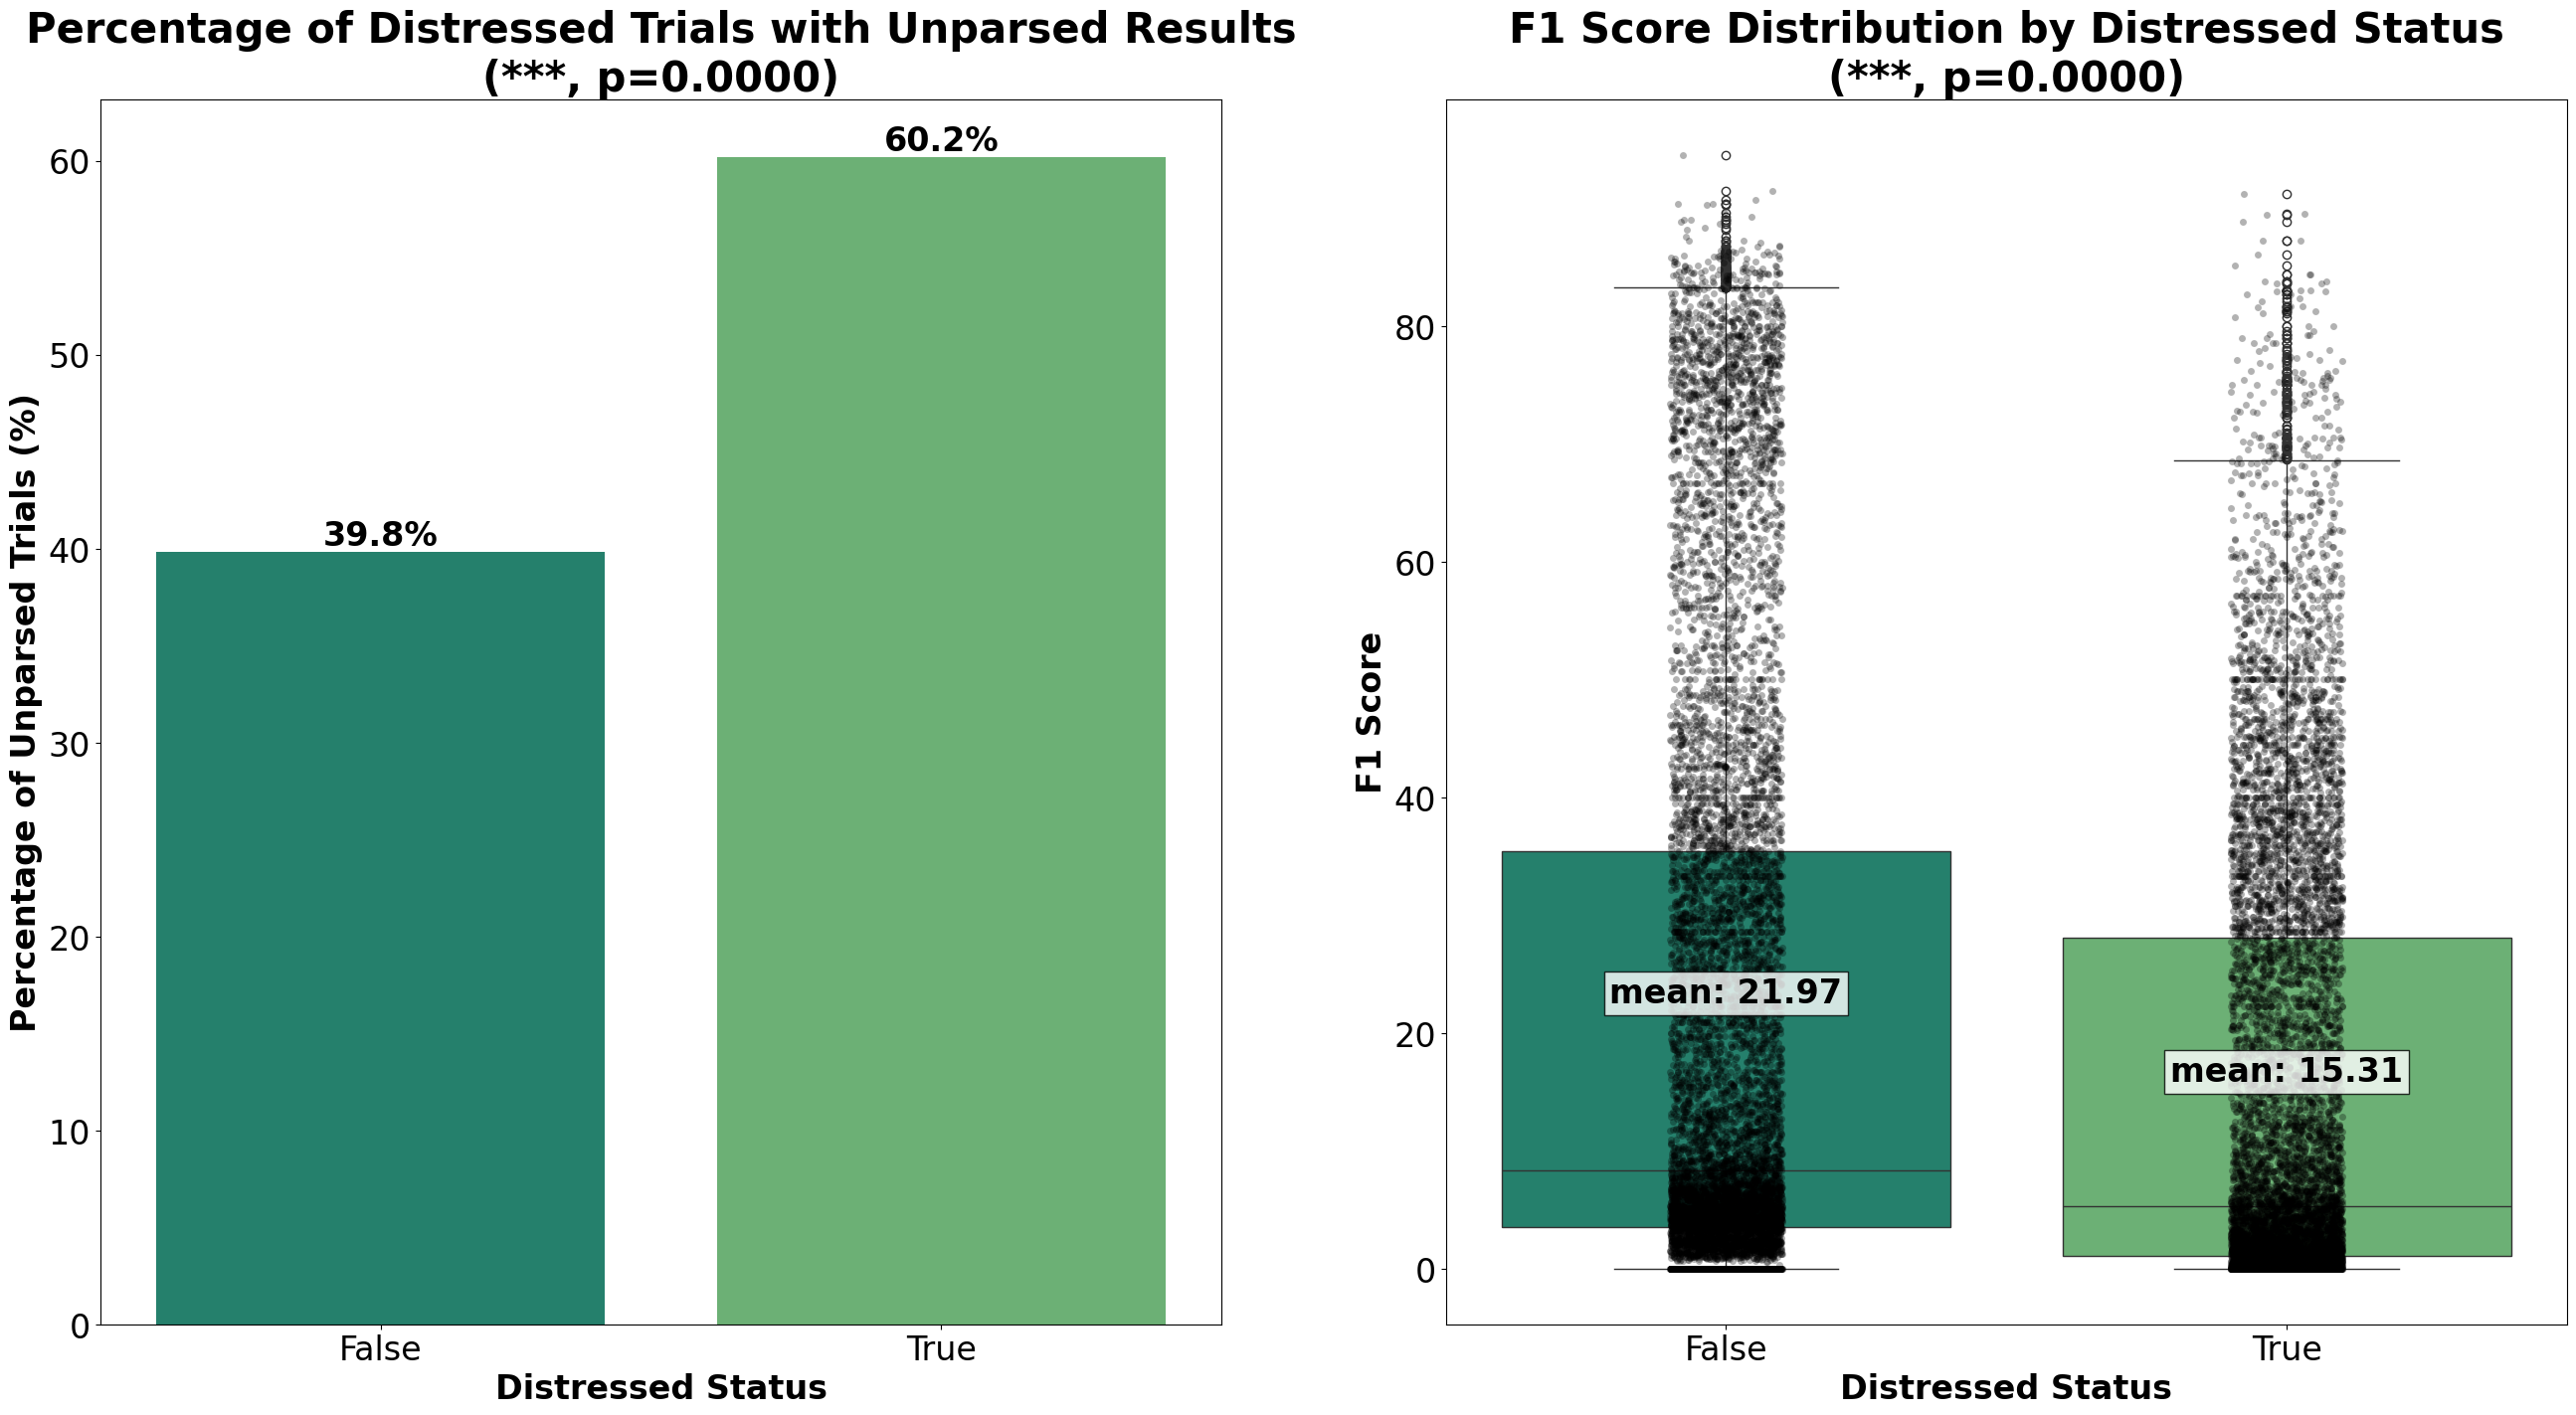

In [176]:
# Enhanced distressed vs non-distressed visualization with corrected significance testing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 16))

# Left plot: Percentage of Distressed Trials with Unparsed Results (with significance)
parse_error = data[data["Parsed"] == False]
distressed_percent = parse_error["Distressed"].value_counts(normalize=True).mul(100)
df_parse = distressed_percent.reset_index()
df_parse.columns = ['Distressed', 'proportion']

# Chi-square test for parsing rates
from scipy.stats import chi2_contingency
parse_crosstab = pd.crosstab(data['Distressed'], data['Parsed'])
print('\nContingency table for parsing rates:')
print(parse_crosstab)
colors = ["#168F75", '#61bb6d']
chi2, p_parse, dof, expected = chi2_contingency(parse_crosstab)
parse_significance = get_significance_symbol(p_parse)

# Check chi-square assumptions
'''min_expected = expected.min()
chi2_valid = min_expected >= 5
print(f'\nChi-square test assumptions:')
print(f'Minimum expected frequency: {min_expected:.2f}')
print(f'Chi-square test valid: {chi2_valid} (should be >= 5)')'''

sns.barplot(data=df_parse, 
            x='Distressed', y='proportion', palette=[colors[0], colors[1]], ax=ax1, errorbar=("sd", 2))

ax1.set_title(f"Percentage of Distressed Trials with Unparsed Results\n({parse_significance}, p={p_parse:.4f})", 
             fontsize=30, fontweight='bold')
ax1.set_xlabel("Distressed Status", fontsize=24, fontweight='bold')
ax1.set_ylabel("Percentage of Unparsed Trials (%)", fontsize=24, fontweight='bold')
ax1.tick_params(axis='x', rotation=0, labelsize=24)
ax1.tick_params(axis='y', labelsize=24)

# Add percentage labels on bars
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.1f%%', fontsize=24, color='black', fontweight='bold')

# Right plot: F1 Score by Distressed Status (with significance)
df_filtered_dist = data[data["Parsed"] != False]  # Filter rows where "Parsed" is not False

# Perform statistical test
distressed_f1 = df_filtered_dist[df_filtered_dist['Distressed'] == True]['F1score']
non_distressed_f1 = df_filtered_dist[df_filtered_dist['Distressed'] == False]['F1score']

# Remove NaN values
distressed_f1 = distressed_f1.dropna()
non_distressed_f1 = non_distressed_f1.dropna()

print(f'\nF1 Score comparison sample sizes:')
print(f'Distressed: {len(distressed_f1)} samples')
print(f'Non-distressed: {len(non_distressed_f1)} samples')

p_f1 = perform_statistical_test(distressed_f1, non_distressed_f1)
f1_significance = get_significance_symbol(p_f1)

# Calculate effect size (Cohen's d)
def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    pooled_std = np.sqrt(((n1 - 1) * group1.var() + (n2 - 1) * group2.var()) / (n1 + n2 - 2))
    return (group1.mean() - group2.mean()) / pooled_std

#effect_size = cohens_d(distressed_f1, non_distressed_f1)
#print(f'Effect size (Cohen\'s d): {effect_size:.3f}')

sns.boxplot(data=df_filtered_dist, x="Distressed", y="F1score", 
           palette=[colors[0], colors[1]], ax=ax2)
sns.stripplot(data=df_filtered_dist, x="Distressed", y="F1score", 
             color="black", dodge=True, alpha=0.3, jitter=True, ax=ax2)

ax2.set_title(f"F1 Score Distribution by Distressed Status\n({f1_significance}, p={p_f1:.4f})", 
             fontsize=30, fontweight='bold')
ax2.set_xlabel("Distressed Status", fontsize=24, fontweight='bold')
ax2.set_ylabel("F1 Score", fontsize=24, fontweight='bold')
ax2.tick_params(axis='x', labelsize=24)
ax2.tick_params(axis='y', labelsize=24)

# Add mean values as text with significance
mean_values = df_filtered_dist.groupby("Distressed")["F1score"].mean()
for i, (status, mean_val) in enumerate(mean_values.items()):
    ax2.text(i, mean_val + 0.02, f'mean: {mean_val:.2f}', 
            ha='center', va='bottom', fontsize=24, color='black', fontweight='bold', 
            bbox=dict(facecolor='white', edgecolor='black', alpha=0.8))

'''# Summary of statistical tests
print('\n' + '='*60)
print('STATISTICAL ANALYSIS SUMMARY')
print('='*60)
print(f'1. Parsing Rate Analysis (Chi-square test):')
print(f'   Chi-square statistic: {chi2:.3f}')
print(f'   p-value: {p_parse:.6f} ({parse_significance})')
print(f'   Test validity: {"Valid" if chi2_valid else "Invalid - use with caution"}')
print(f'\n2. F1 Score Analysis:')
print(f'   Test p-value: {p_f1:.6f} ({f1_significance})')
print(f'   Effect size (Cohen\'s d): {effect_size:.3f}')
print(f'   Effect size interpretation: ', end='')
if abs(effect_size) < 0.2:
    print('Small effect')
elif abs(effect_size) < 0.5:
    print('Small to medium effect')
elif abs(effect_size) < 0.8:
    print('Medium to large effect')
else:
    print('Large effect')'''

/var/folders/2r/vpjdzw2s7jl5204hqh_k3c9h0000gp/T/ipykernel_5588/2665602335.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data.Prompt.fillna("None", inplace=True)
/var/folders/2r/vpjdzw2s7jl5204hqh_k3c9h0000gp/T/ipykernel_5588/2665602335.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

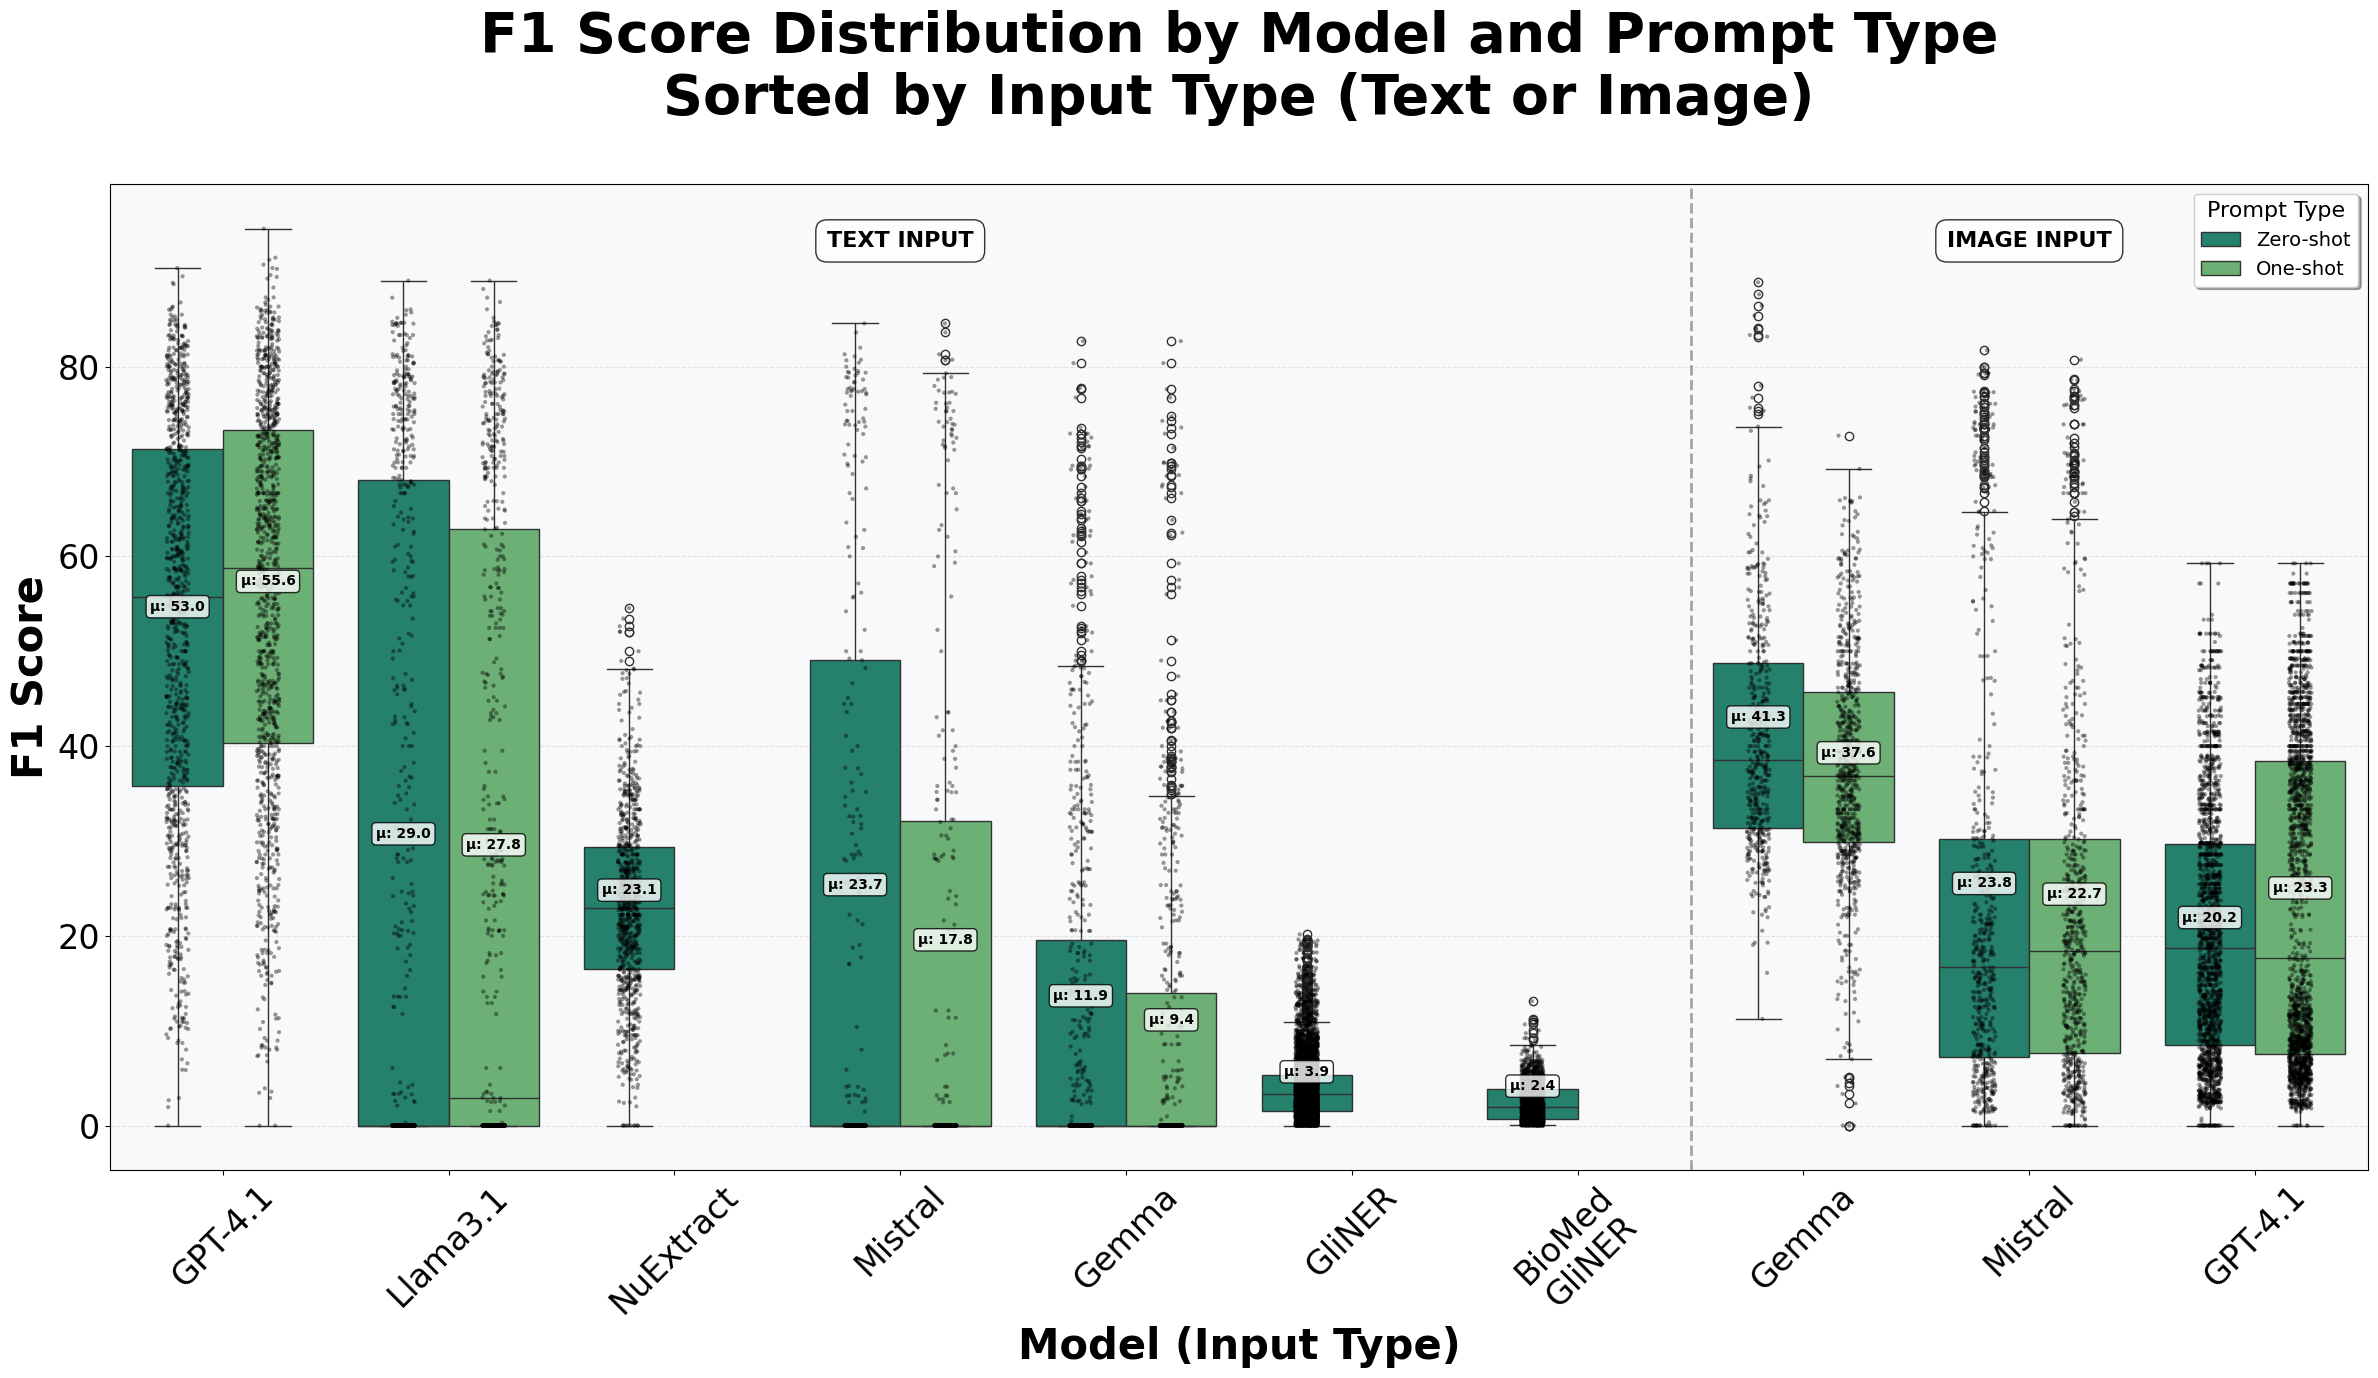


Summary of Significant Within-Model Differences (One-shot vs Zero-shot):
gpt-4.1-mini                             p=0.000000   ***   (mean diff: 35.43)
gpt-4.1-mini                             p=0.000000   ***   (mean diff: 32.77)
gpt-4.1-mini                             p=0.000000   ***   (mean diff: 32.31)
gpt-4.1-mini                             p=0.000000   ***   (mean diff: 29.65)
gemma327b                                p=0.000000   ***   (mean diff: 28.16)
gemma327b                                p=0.000000   ***   (mean diff: 31.93)
gemma327b                                p=0.000000   ***   (mean diff: 25.62)
gemma327b                                p=0.000000   ***   (mean diff: 29.39)
mistral(24b)                             p=0.000000   ***   (mean diff: 4.81)
mistral(24b)                             p=0.000000   ***   (mean diff: 5.94)
mistral(24b)                             p=0.000000   ***   (mean diff: 0.13)
mistral(24b)                             p=0.000000   ***   

In [177]:

from scipy.stats import mannwhitneyu, ttest_ind, normaltest
from statsmodels.stats.multitest import multipletests
from itertools import combinations


# Load the data
data = pd.read_csv('Hospitaltest.csv')
d = pd.read_csv("Hospital.csv")

# Clean and combine data
data.drop(columns=[col for col in data.columns if 'unnamed' in col.lower()], inplace=True)
d.drop(columns=[col for col in d.columns if 'unnamed' in col.lower()], inplace=True)
data = pd.concat([data, d], ignore_index=True)

# Set up colors (two shades of green)
colors = ['#64bb46', "#DDF1D6", "#21520F"]

# Process image indicator
data['Image'] = data.LLM.apply(lambda x: True if "image" in x.lower() else False)

# Updated LLM labeling to properly handle GLiNER models as zero-shot
def label_llm_with_prompt_type(row):
    llm_name = row['LLM']
    prompt = row['Prompt']
    
    # Check if it's a GLiNER model (various naming patterns)
    if 'GLiNER' in llm_name or 'gliner' in llm_name.lower():
        return llm_name + " (Zero-shot)"
    elif prompt == "LTNER/GPT-NER":
        return llm_name + " (One-shot)"
    elif prompt == "Normal":
        return llm_name + " (Zero-shot)"
    else:
        return llm_name

data['LLM'] = data.apply(label_llm_with_prompt_type, axis=1)
data.Prompt.fillna("None", inplace=True)
data.Parsed.fillna(True, inplace=True)

def get_significance_symbol(p_value):
    """Convert p-value to significance symbol"""
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return 'ns'

# Prepare the data for comprehensive analysis
df_box = data.copy()
df_box = df_box[df_box['Parsed'] == True]  # Only successfully parsed data
df_box['F1score'] = pd.to_numeric(df_box['F1score'], errors='coerce')
df_box = df_box.dropna(subset=['F1score'])

# Clean up model names and create proper groupings
df_box['Model_Base'] = df_box['LLM'].str.replace('*ImageInput*', '').str.replace(' (One-shot)', '').str.replace(' (Zero-shot)', '')
df_box['Input_Type'] = df_box['LLM'].apply(lambda x: 'Image' if '*ImageInput*' in x else 'Text')
df_box['Prompt_Type'] = df_box['Prompt'].map({
    'LTNER/GPT-NER': 'One-shot',
    'Normal': 'Zero-shot',
    'None': 'Zero-shot'
})

# Filter out models without proper prompt categorization
df_box = df_box[df_box['Prompt_Type'].notna()]

# Create a combined identifier for plotting
df_box['Model_Input_Combo'] = df_box['Model_Base'] + ' (' + df_box['Input_Type'] + ')'

# Get models that have sufficient data for both prompt types
model_prompt_counts = df_box.groupby(['Model_Input_Combo', 'Prompt_Type']).size().reset_index(name='count')
models_with_sufficient_data = model_prompt_counts[model_prompt_counts['count'] >= 10]['Model_Input_Combo'].unique()

# Filter to models with sufficient data
df_filtered_box = df_box[df_box['Model_Input_Combo'].isin(models_with_sufficient_data)]

# Calculate mean F1 scores for ordering
model_means = df_filtered_box.groupby('Model_Input_Combo')['F1score'].mean().sort_values(ascending=False)
model_order_box = model_means.index.tolist()

# Separate text and image models for better organization
text_models = [m for m in model_order_box if '(Text)' in m]
image_models = [m for m in model_order_box if '(Image)' in m]
final_model_order = text_models + image_models

# Define colors for prompt types (two shades of green)
prompt_colors = {'Zero-shot': "#168F75", 'One-shot': '#61bb6d'}

# Create the figure
fig, ax = plt.subplots(figsize=(24, 14))

# Create box plot
box_plot = sns.boxplot(data=df_filtered_box, 
            x='Model_Input_Combo', 
            y='F1score', 
            hue='Prompt_Type',
            order=final_model_order,
            palette=prompt_colors,
            ax=ax)

# Add strip plot for individual data points
sns.stripplot(data=df_filtered_box, 
              x='Model_Input_Combo', 
              y='F1score', 
              hue='Prompt_Type',
              order=final_model_order,
              palette=["Black", "Black"],
              size=3, alpha=0.4, dodge=True, ax=ax)

mean_values = df_filtered_box.groupby(["Model_Input_Combo"])["F1score"].mean()
# Calculate mean F1 scores by model and prompt type for annotation
model_prompt_means = df_filtered_box.groupby(['Model_Input_Combo', 'Prompt_Type'])['F1score'].mean().reset_index()

# Add mean annotations for each box (prompt type)
for _, row in model_prompt_means.iterrows():
    model = row['Model_Input_Combo']
    prompt_type = row['Prompt_Type']
    mean_val = row['F1score']
    
    # Find the position of this model in the final order
    x_pos = final_model_order.index(model)
    
    # Adjust x position based on prompt type (dodge effect)
    if prompt_type == 'Zero-shot':
        x_offset = -0.2
    else:  # One-shot
        x_offset = 0.2
    
    ax.text(x_pos + x_offset, mean_val + 1, f'μ: {mean_val:.1f}', 
            ha='center', va='bottom', fontsize=10, color='black', fontweight='bold', 
            bbox=dict(facecolor='white', edgecolor='black', alpha=0.8, boxstyle='round,pad=0.3'))

# Perform comprehensive statistical testing
def perform_all_pairwise_tests(df, models):
    """Perform all pairwise statistical tests between model-prompt combinations"""
    results = []
    comparisons = []
    p_values = []
    
    # Get all unique combinations of model and prompt type
    conditions = []
    for model in models:
        model_data = df[df['Model_Input_Combo'] == model]
        available_prompts = model_data['Prompt_Type'].unique()
        for prompt in available_prompts:
            if len(model_data[model_data['Prompt_Type'] == prompt]) >= 5:
                conditions.append((model, prompt))
    
    # Perform pairwise comparisons
    for i, (model1, prompt1) in enumerate(conditions):
        for j, (model2, prompt2) in enumerate(conditions[i+1:], i+1):
            # Get data for both conditions
            data1 = df[(df['Model_Input_Combo'] == model1) & (df['Prompt_Type'] == prompt1)]['F1score']
            data2 = df[(df['Model_Input_Combo'] == model2) & (df['Prompt_Type'] == prompt2)]['F1score']
            
            if len(data1) >= 5 and len(data2) >= 5:
                # Perform Mann-Whitney U test
                try:
                    _, p_value = mannwhitneyu(data1, data2, alternative='two-sided')
                    p_values.append(p_value)
                    comparisons.append(((model1, prompt1), (model2, prompt2)))
                    results.append({
                        'condition1': f'{model1} ({prompt1})',
                        'condition2': f'{model2} ({prompt2})',
                        'p_value': p_value,
                        'mean1': data1.mean(),
                        'mean2': data2.mean()
                    })
                except:
                    continue
    
    return results, p_values, comparisons

# Perform statistical tests
test_results, raw_p_values, comparison_pairs = perform_all_pairwise_tests(df_filtered_box, final_model_order)

# Apply multiple comparison correction
if len(raw_p_values) > 0:
    rejected, p_corrected, _, _ = multipletests(raw_p_values, method='fdr_bh')
else:
    rejected, p_corrected = [], []

# Add significance indicators for within-model comparisons

# Customize the plot
# Clean up x-axis labels - remove (Text) and (Image) and standardize model names
def clean_model_name(name):
    # Remove input type indicators
    name = name.replace(' (Text)', '').replace(' (Image)', '')
    
    # Standardize model names
    if 'gpt-4.1-mini' in name:
        return 'GPT-4.1'
    elif 'llama3.170b' in name:
        return 'Llama3.1'
    elif 'NuExtract:4B' in name:
        return 'NuExtract'
    elif 'mistral(24b)' in name:
        return 'Mistral'
    elif 'gemma327b' in name:
        return 'Gemma'
    elif name == 'GLiNER':
        return 'GliNER'
    elif 'Ihor/gliner-biomed-base-v1.0' in name:
        return 'BioMed\nGliNER'
    else:
        return name

# Get current labels and clean them
current_labels = [clean_model_name(label.get_text()) for label in ax.get_xticklabels()]
ax.set_xticklabels(current_labels)
ax.set_title('F1 Score Distribution by Model and Prompt Type\nSorted by Input Type (Text or Image)', 
            fontsize=40, fontweight='bold', pad=50)
ax.set_xlabel('Model (Input Type)', fontsize=30, fontweight='bold')
ax.set_ylabel('F1 Score', fontsize=30, fontweight='bold')

# Rotate x-axis labels and adjust size
ax.tick_params(axis='x', rotation=45, labelsize=24)
ax.tick_params(axis='y', labelsize=24)

# Add vertical line to separate text and image models
if len(text_models) > 0:
    separator_x = len(text_models) - 0.5
    ax.axvline(x=separator_x, color='gray', linestyle='--', alpha=0.7, linewidth=2)
    
    # Add section labels
    ax.text(len(text_models)/2 - 0.5, ax.get_ylim()[1] * 0.95, 'TEXT INPUT', 
           ha='center', va='top', fontsize=16, fontweight='bold', 
           bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))
    ax.text(len(text_models) + len(image_models)/2 - 0.5, ax.get_ylim()[1] * 0.95, 'IMAGE INPUT', 
           ha='center', va='top', fontsize=16, fontweight='bold',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

# Customize legend
handles, labels = ax.get_legend_handles_labels()
# Remove duplicate legend entries from stripplot
ax.legend(handles[:2], labels[:2], title='Prompt Type', title_fontsize=16, fontsize=14,
         loc='upper right', frameon=True, fancybox=True, shadow=True)

# Add grid for better readability
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.8)
ax.set_axisbelow(True)

# Set clean background
ax.set_facecolor('#f8f9fa')

# Add text box with significance explanation


plt.tight_layout()
plt.show()

# Print summary of significant within-model differences
print('\nSummary of Significant Within-Model Differences (One-shot vs Zero-shot):')
print('=' * 80)
within_model_results = []
for i, result in enumerate(test_results):
    if i < len(p_corrected):
        p_val = p_corrected[i]
        cond1 = result['condition1']
        cond2 = result['condition2']
        model1 = cond1.split(' (')[0]
        model2 = cond2.split(' (')[0]
        
        if model1 == model2:  # Within-model comparison
            within_model_results.append({
                'model': model1,
                'p_value': p_val,
                'mean_diff': abs(result['mean1'] - result['mean2']),
                'significance': get_significance_symbol(p_val)
            })

# Sort by significance
within_model_results.sort(key=lambda x: x['p_value'])

for result in within_model_results:
    print(f"{result['model']:<40} p={result['p_value']:<10.6f} {result['significance']:<5} (mean diff: {result['mean_diff']:.2f})")

print(f'\nTotal comparisons performed: {len(test_results)}')
print(f'Within-model comparisons: {len(within_model_results)}')
print(f'Significant within-model differences: {sum(1 for r in within_model_results if r["p_value"] < 0.05)}')

# Add mean F1 scores as white boxes on the boxplot#


# error analysis

In [178]:
# Load and analyze the field_analysis.csv file
def change_name(x):
    str(x)
    x = x.lower()
    if "NuExtract" in x:
        return "NuExtract"
    elif "gpt" in x:
        return "GPT-4.1"
    elif "llama" in x: 
        return "Llama3.1"
    elif "mistral" in x:
        return "Mistral"
    elif "gemma" in x:
        return "Gemma"
    elif "biomed" in x:
        return "BioMed GliNER"
    elif "gliNER" in x:
        return "GliNER"
    return x    
field_data = pd.read_csv('field_analysis.csv')
field_data[model] = field_data[model].apply(change_name)
# Calculate proportions of each error field
error_counts = field_data.groupby("model").value_counts().sort_values(ascending=False)
error_proportions = error_counts / error_counts.sum()

# Create a bar chart showing the most common error fields
plt.figure(figsize=(16, 10))
ax = error_proportions.plot(kind='bar', color=colors[0])

plt.title('Most Common Error Fields\n(Proportion of Total Errors)', 
         fontsize=24, fontweight='bold', pad=20)
plt.xlabel('Error Field', fontsize=18, fontweight='bold')
plt.ylabel('Proportion of Total Errors', fontsize=18, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)

# Add percentage labels on bars
for i, (field, proportion) in enumerate(error_proportions.items()):
    ax.text(i, proportion + 0.005, f'{proportion:.1%}', 
           ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.8)
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f'Total number of errors: {error_counts.sum()}')
print(f'Number of unique error fields: {len(error_counts)}')
print('\nTop 10 most common error fields:')
for field, count in error_counts.head(10).items():
    print(f'{field:<30} {count:>6} ({count/error_counts.sum():.1%})')

KeyError: 'mistral(24b) (Text)'

In [ ]:
# Comprehensive Error Field Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
valid_fields= ["date_collected",
"date_received", 
"date_verified",
"report_type",
'testing_context'
"ordering_clinic",
"testing_laboratory",
"sequencing_scope",
"sample_type",
"analysis_type",
"num_tested_genes",
"refseq_mrna",
"num_variants",
"reference_genome",
"gene_symbol",
"variant_id",
"chromosome",
"hgvsg",
"hgvsc",
"hgvsp",
"transcript_id",
"exon",
"zygosity",
"interpretation",
"mafac",
"mafan",
"mafaf",
"mega_hgvs",
"type",
"total", 
"model"]

def test_col(col1):
    col = str(col1).strip().replace("fp_", "").replace("_fn", "").replace("_fp","").replace("fn_", "").strip().lower()
    if col in valid_fields:
        return False
    return True
# Load and prepare field analysis data
try:
    field_data = pd.read_csv('field_analysis.csv')
    field_data.drop(columns=[col for col in field_data.columns if test_col(col)], inplace=True)
    print("\nFirst few rows:")
    print(f"Columns: {field_data.columns.tolist()}")
    print(f"Field analysis data loaded successfully. Shape: {field_data.shape}")

    print(field_data.head())
    
    # Clean model names for consistency
    def standardize_model_name(x):
        if pd.isna(x):
            return 'Unknown'
        x = str(x).lower()
        if "nuextract" in x:
            return "NuExtract"
        elif "gpt" in x:
            return "GPT-4.1"
        elif "llama" in x: 
            return "Llama3.1"
        elif "mistral" in x:
            return "Mistral"
        elif "gemma" in x:
            return "Gemma"
        elif "biomed" in x:
            return "BioMed GliNER"
        elif "gliner" in x:
            return "GliNER"
        return x
    
    # Determine the correct column name for the model
    model_col = None
    field_col = None
    
    # Look for model column
    for col in field_data.columns:
        if 'model' in col.lower() or 'llm' in col.lower():
            model_col = col
            break
    
    # Look for field/error column
    for col in field_data.columns:
        if 'field' in col.lower() or 'error' in col.lower() or 'missing' in col.lower():
            field_col = col
            break
    
    print(f"\nDetected model column: {model_col}")
    print(f"Detected field column: {field_col}")
    
    if model_col and field_col:
        # Clean the model names
        field_data['Model_Clean'] = field_data[model_col].apply(standardize_model_name)
        
        # Calculate error counts by field and model
        error_summary = field_data.groupby([field_col, 'Model_Clean']).size().reset_index(name='Count')
        total_errors_by_field = field_data[field_col].value_counts()
        total_errors_by_model = field_data['Model_Clean'].value_counts()
        
        print(f"\nTotal errors by field (top 10):")
        print(total_errors_by_field.head(10))
        print(f"\nTotal errors by model:")
        print(total_errors_by_model)
        
    else:
        print("Could not identify model and field columns. Please check the data structure.")
        print("Available columns:", field_data.columns.tolist())

except Exception as e:
    print(f"Error loading field_analysis.csv: {e}")
    print("The file might be too large or have a different structure.")
    field_data = None


First few rows:
Columns: ['model', 'total_fp', 'total_fn', 'fp_analysis_type', 'fn_analysis_type', 'fp_chromosome', 'fn_chromosome', 'fp_date_collected', 'fn_date_collected', 'fp_date_received', 'fn_date_received', 'fp_date_verified', 'fn_date_verified', 'fp_exon', 'fn_exon', 'fp_gene_symbol', 'fn_gene_symbol', 'fp_hgvsc', 'fn_hgvsc', 'fp_hgvsg', 'fn_hgvsg', 'fp_hgvsp', 'fn_hgvsp', 'fp_interpretation', 'fn_interpretation', 'fp_mafac', 'fn_mafac', 'fp_mafaf', 'fn_mafaf', 'fp_mafan', 'fn_mafan', 'fp_mega_hgvs', 'fn_mega_hgvs', 'fp_num_tested_genes', 'fn_num_tested_genes', 'fp_num_variants', 'fn_num_variants', 'fp_reference_genome', 'fn_reference_genome', 'fp_refseq_mrna', 'fn_refseq_mrna', 'fp_report_type', 'fn_report_type', 'fp_sample_type', 'fn_sample_type', 'fp_sequencing_scope', 'fn_sequencing_scope', 'fp_testing_laboratory', 'fn_testing_laboratory', 'fp_transcript_id', 'fn_transcript_id', 'fp_type', 'fn_type', 'fp_variant_id', 'fn_variant_id', 'fp_zygosity', 'fn_zygosity', 'fp_Inte

In [ ]:
# Create visualizations if data was loaded successfully
if field_data is not None and model_col and field_col:
    # Set up the plotting style
    colors = ['#64bb46', '#DDF1D6', '#21520F', '#168F75', '#61bb6d']
    plt.style.use('default')
    
    # 1. Bar plot of most common error fields
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 16))
    
    # Calculate error rates
    error_rates = total_errors_by_field.head(15)  # Top 15 most common errors
    error_percentages = (error_rates / error_rates.sum() * 100)
    
    # Create horizontal bar plot
    bars = ax1.barh(range(len(error_rates)), error_rates.values, color=colors[0])
    ax1.set_yticks(range(len(error_rates)))
    ax1.set_yticklabels(error_rates.index, fontsize=12)
    ax1.set_xlabel('Number of Errors', fontsize=14, fontweight='bold')
    ax1.set_title('Most Common Error Fields\n(Top 15 by Frequency)', fontsize=18, fontweight='bold', pad=20)
    
    # Add count labels on bars
    for i, (bar, count, pct) in enumerate(zip(bars, error_rates.values, error_percentages.values)):
        ax1.text(bar.get_width() + count*0.01, bar.get_y() + bar.get_height()/2, 
                f'{count} ({pct:.1f}%)', ha='left', va='center', fontsize=10, fontweight='bold')
    
    ax1.grid(axis='x', alpha=0.3, linestyle='--')
    ax1.set_axisbelow(True)
    
    # 2. Heatmap showing error distribution by model and field
    # Create pivot table for heatmap
    top_fields = total_errors_by_field.head(10).index  # Top 10 fields for readability
    heatmap_data = field_data[field_data[field_col].isin(top_fields)]
    
    # Create pivot table
    pivot_table = heatmap_data.pivot_table(
        index=field_col, 
        columns='Model_Clean', 
        values=field_col,  # We'll count occurrences
        aggfunc='count',
        fill_value=0
    )
    
    # Calculate error rates (percentage of each model's total errors)
    error_rate_matrix = pivot_table.div(pivot_table.sum(axis=0), axis=1) * 100
    
    # Create heatmap
    sns.heatmap(error_rate_matrix, 
                annot=True, 
                fmt='.1f',
                cmap='Greens',
                cbar_kws={'label': 'Error Rate (% of model total)'},
                ax=ax2,
                annot_kws={'fontsize': 9})
    
    ax2.set_title('Error Field Distribution by Model\n(Percentage of Each Model\'s Total Errors)', 
                 fontsize=18, fontweight='bold', pad=20)
    ax2.set_xlabel('Model', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Error Field', fontsize=14, fontweight='bold')
    ax2.tick_params(axis='x', rotation=45, labelsize=12)
    ax2.tick_params(axis='y', rotation=0, labelsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*80)
    print("ERROR ANALYSIS SUMMARY")
    print("="*80)
    print(f"Total number of errors recorded: {len(field_data):,}")
    print(f"Number of unique error fields: {field_data[field_col].nunique()}")
    print(f"Number of models analyzed: {field_data['Model_Clean'].nunique()}")
    
    print(f"\nTop 10 most common error fields:")
    for i, (field, count) in enumerate(total_errors_by_field.head(10).items(), 1):
        percentage = (count / len(field_data)) * 100
        print(f"{i:2d}. {field:<40} {count:>8,} ({percentage:5.1f}%)")
    
    print(f"\nError distribution by model:")
    for model, count in total_errors_by_model.items():
        percentage = (count / len(field_data)) * 100
        print(f"{model:<20} {count:>8,} ({percentage:5.1f}%)")

else:
    print("Cannot create visualizations - field analysis data not available or improperly formatted.")

Cannot create visualizations - field analysis data not available or improperly formatted.


In [ ]:
# Alternative visualization: Field error rates with confidence intervals
if field_data is not None and model_col and field_col:
    
    # Create a more detailed analysis
    fig, ax = plt.subplots(figsize=(16, 12))
    
    # Calculate error rates and confidence intervals for top fields
    top_15_fields = total_errors_by_field.head(15)
    
    # Prepare data for plotting
    field_names = []
    error_counts = []
    error_rates = []
    
    total_records = len(field_data)
    
    for field, count in top_15_fields.items():
        field_names.append(field)
        error_counts.append(count)
        rate = (count / total_records) * 100
        error_rates.append(rate)
    
    # Create the plot
    y_pos = np.arange(len(field_names))
    bars = ax.barh(y_pos, error_rates, color=colors[0], alpha=0.8)
    
    # Customize the plot
    ax.set_yticks(y_pos)
    ax.set_yticklabels(field_names, fontsize=11)
    ax.set_xlabel('Error Rate (% of Total Records)', fontsize=14, fontweight='bold')
    ax.set_title('Error Field Analysis: Most Common Sites of Errors\n(Percentage of Total Records)', 
                fontsize=16, fontweight='bold', pad=20)
    
    # Add value labels on bars
    for i, (bar, count, rate) in enumerate(zip(bars, error_counts, error_rates)):
        ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                f'{rate:.1f}% (n={count:,})', 
                ha='left', va='center', fontsize=10, fontweight='bold')
    
    # Add grid and styling
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Create a summary table of the worst performing fields by model
    print("\n" + "="*80)
    print("DETAILED FIELD ERROR ANALYSIS BY MODEL")
    print("="*80)
    
    # For each of the top 5 error fields, show which models struggle most
    for field in total_errors_by_field.head(5).index:
        field_errors = field_data[field_data[field_col] == field]
        model_errors = field_errors['Model_Clean'].value_counts()
        model_rates = (model_errors / total_errors_by_model * 100).fillna(0)
        
        print(f"\n{field}:")
        print(f"  Total occurrences: {len(field_errors):,}")
        print(f"  Models with highest error rates:")
        for model, rate in model_rates.head(3).items():
            count = model_errors.get(model, 0)
            print(f"    {model:<20} {count:>6,} errors ({rate:5.1f}% of model's total)")

else:
    print("Field analysis data not available for detailed visualization.")

Field analysis data not available for detailed visualization.


# Visualization: Most Common Error Locations
This cell creates a comprehensive visualization of the most frequent locations (fields) where errors are occurring across all models. The analysis helps identify which specific data fields are most problematic and may require targeted improvements.

Field analysis data loaded successfully. Shape: (136991, 2)
Columns: ['model', 'field']

First few rows:
       model           field
0  NuExtract   analysis_type
1  NuExtract      chromosome
2  NuExtract  date_collected
3  NuExtract   date_received
4  NuExtract     gene_symbol

Total error records: 136,991
Unique models: 5
Unique error fields: 30


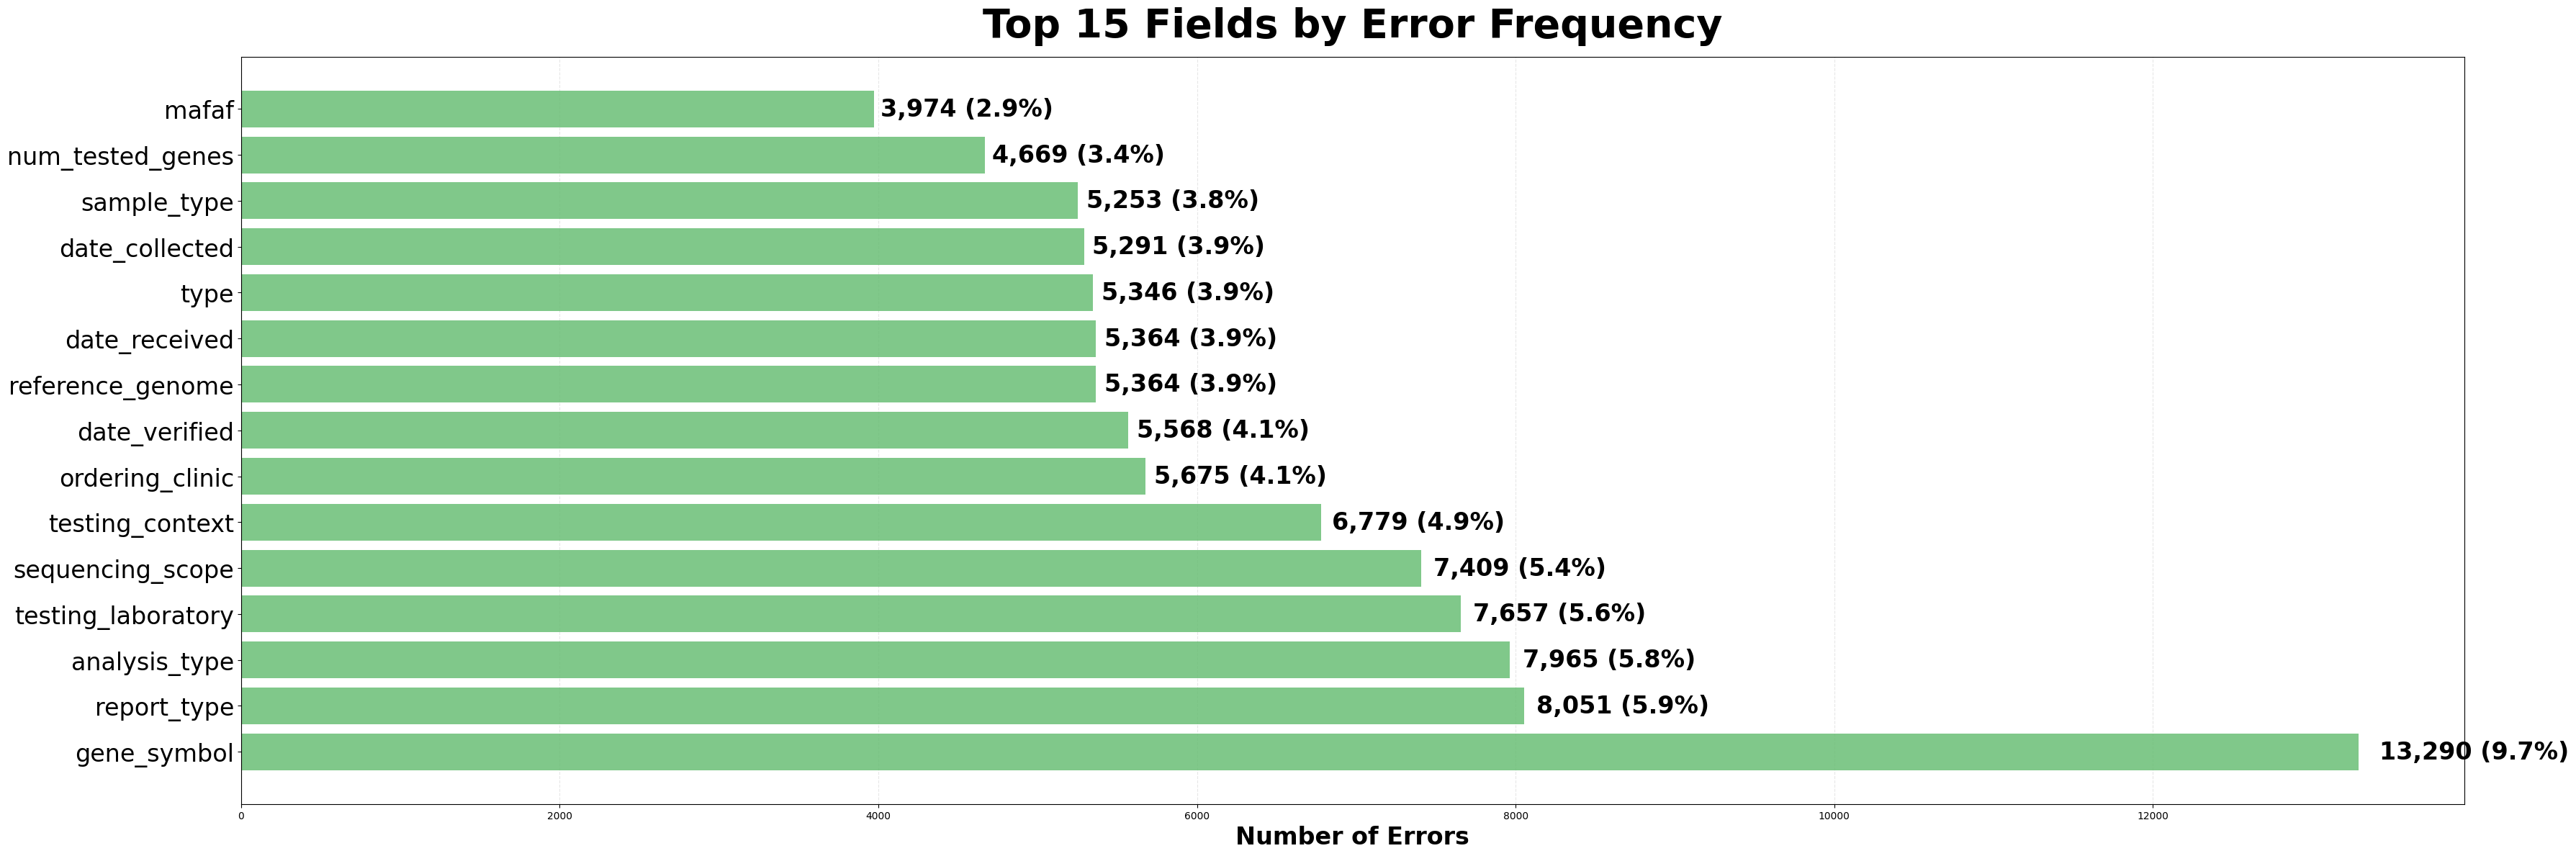

In [ ]:
# Load and visualize the formatted field analysis data
try:
    # Load the properly formatted field analysis data
    field_data = pd.read_csv('field_analysis_formatted.csv')
    print(f"Field analysis data loaded successfully. Shape: {field_data.shape}")
    print(f"Columns: {field_data.columns.tolist()}")
    print("\nFirst few rows:")
    print(field_data.head())
    
    # Calculate error counts by field
    total_errors_by_field = field_data['field'].value_counts()
    total_errors_by_model = field_data['model'].value_counts()
    
    print(f"\nTotal error records: {len(field_data):,}")
    print(f"Unique models: {field_data['model'].nunique()}")
    print(f"Unique error fields: {field_data['field'].nunique()}")
    
    # Set up the plotting parameters
    fig, ax = plt.subplots(figsize=(36, 12))
    
    # 1. Horizontal bar chart of top error fields
    top_error_fields = total_errors_by_field.head(15)
    error_percentages = (top_error_fields / len(field_data) * 100)
    
    # Create horizontal bar plot
    bars = ax.barh(range(len(top_error_fields)), top_error_fields.values, color="#61bb6d", alpha=0.8)
    ax.set_yticks(range(len(top_error_fields)))
    ax.set_yticklabels(top_error_fields.index, fontsize=24)
    ax.set_xlabel('Number of Errors', fontsize=24, fontweight='bold')
    ax.set_title('Top 15 Fields by Error Frequency', 
                 fontsize=40, fontweight='bold', pad=20)
    
    # Add count and percentage labels on bars
    for i, (bar, count, pct) in enumerate(zip(bars, top_error_fields.values, error_percentages.values)):
        ax.text(bar.get_width() + count*0.01, bar.get_y() + bar.get_height()/2, 
                f'{count:,} ({pct:.1f}%)', ha='left', va='center', 
                fontsize=24, fontweight='bold')
    
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    
    '''    # 2. Error rate by field (percentage of total records)
    y_pos = np.arange(len(top_error_fields))
    bars2 = ax2.barh(y_pos, error_percentages.values, color=colors[2], alpha=0.8)
    
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(top_error_fields.index, fontsize=12)
    ax2.set_xlabel('Error Rate (% of Total Records)', fontsize=14, fontweight='bold')
    ax2.set_title('Error Field Analysis: Error Rates by Field\n(Percentage of All Analyzed Records)', 
                 fontsize=18, fontweight='bold', pad=20)
    
    # Add percentage labels
    for i, (bar, rate) in enumerate(zip(bars2, error_percentages.values)):
        ax2.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                f'{rate:.1f}%', ha='left', va='center', 
                fontsize=10, fontweight='bold')
    
    ax2.grid(axis='x', alpha=0.3, linestyle='--')
    ax2.set_axisbelow(True)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)'''
    
    plt.tight_layout()
    plt.show()
    
except FileNotFoundError:
    print('Error: field_analysis_formatted.csv not found!')
    print('Please make sure the file exists in the current directory.')
except Exception as e:
    print(f'Error loading field analysis data: {e}')
    print('Please check that the file is properly formatted.')